## Feature detection and layer characteristics

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
import cmocean
import math
import gsw
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams['font.size'] = '12'

In [2]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

In [3]:
import imp
import src.importData as imports
import src.calc as calc
import src.interpolation as interp
import src.plots as plots
import src.stats as stats
import src.concat as ct
import src.velocities as vel
import src.settings as settings

In [4]:
fltdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
floatids = [8489, 8490, 8492, 8493]
ema = imports.importFloatData(floatids)

rot_vels = {}               
for floatid in [8489, 8492, 8493]:
    #rotated velocities
    file = os.path.join(fltdir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)
    
# half-inertial pair averaged float dataset
ds_8490 = imports.sub_inertial_ds_prev(ema, [8490], fltdir, xdim = 'distance')
ds = imports.sub_inertial_ds(ema, [8489, 8492, 8493], fltdir, xdim = 'distance', rot_vels = rot_vels)

ds[8490] = ds_8490[8490]
ds = dict(sorted(ds.items()))

In [5]:
# Path to save figures
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')

### EM-APEX floats

In [6]:
floatids = [8489, 8490, 8492, 8493]

imp.reload(calc)

CT, SA, P = {}, {}, {}
mld_on_d = {}
dyn_m = {}
mld = {}
dens = {}
N2 = {}

for floatid in floatids:
#     newfloat = settings.distanceAsCoord(ema[floatid], rs = True)
#     CT[floatid], SA[floatid], P[floatid] = newfloat.CT, newfloat.SA, newfloat.pressure

    CT[floatid], SA[floatid], P[floatid] = ds[floatid].CT, ds[floatid].SA, ds[floatid].pressure
    
    dens[floatid] = calc.potentialDensity(P[floatid], SA[floatid], CT[floatid])

    mld[floatid] = calc.MLD(dens[floatid], criteria = 0.03, pref = 10)
    mld_on_d[floatid] = calc.MLD_on_dens(dens[floatid], criteria = 0.03, pref = 10)
    
    N2[floatid] = calc.N2(CT[floatid], SA[floatid], ds[floatid].latitude, smooth = False)
    
    dyn_m[floatid] = calc.dynamicHeight(CT[floatid], SA[floatid])[1] 

In [7]:
S_concat = ct.joinFloats(SA, 'distance', new_dim = False)
T_concat = ct.joinFloats(CT, 'distance', new_dim = False)
pdens = ct.joinFloats(dens, 'distance', new_dim = False)

Tdens_ds, end_dist, d_rs = ct.concatenated_flts(CT, floatids, interp_to_dens = True, pdens = pdens, new_dim = False, rs = False)
Sdens_ds, end_dist, d_rs = ct.concatenated_flts(SA, floatids, interp_to_dens = True, pdens = pdens, new_dim = False, rs = False)

ticks, values, flt_dist_loc = plots.concatTickValues(d_rs)
flt_ind = np.where(Tdens_ds.distance == 0)[0].tolist()
flt_ind.append(len(Tdens_ds))

In [8]:
imp.reload(calc)

DSC = {}
DSC_smooth = {}
S_dens, T_dens = {}, {}
p_on_dens = {}

i = 0 
for floatid in floatids:
    
    S = Sdens_ds[flt_ind[i]:flt_ind[i+1]]
    T = Tdens_ds[flt_ind[i]:flt_ind[i+1]]
    density = pdens[flt_ind[i]:flt_ind[i+1]]
    S_dens[floatid], T_dens[floatid] = S, T

    p = ds[floatid].pressure
    DSC[floatid], DSC_smooth[floatid] = calc.DSC(T, S, pdens = density)
    
    pressure = xr.DataArray(np.tile(p, (len(CT[floatid].distance), 1)), 
                            dims = CT[floatid].dims, 
                            coords = CT[floatid].coords)
    
    p_on_dens[floatid] = interp.to_pdens_grid(pressure, density, zdim = 'pressure', dens_interval = 0.01)
    
    i += 1

#### Check assumption of $\alpha_{\sigma} \theta_{\sigma} << \alpha \theta_{\sigma\sigma}$

In [9]:
theta = {}
alpha = {}

i = 0 
for floatid in floatids:
    
    theta[floatid] = gsw.pt_from_CT(S_dens[floatid], T_dens[floatid])
    alpha[floatid] = gsw.rho_alpha_beta(S_dens[floatid], T_dens[floatid], 0)[1]


In [13]:
floatid = 8492
theta_drho = theta[floatid].differentiate('potential_density')
alpha_drho = alpha[floatid].differentiate('potential_density')
theta_drho_drho = theta[floatid].differentiate('potential_density').differentiate('potential_density')

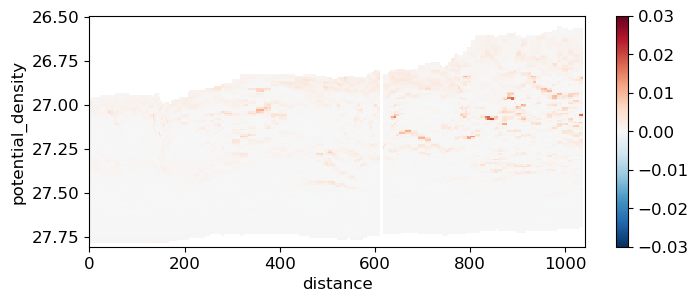

In [14]:
fig, ax = plt.subplots(figsize = (8,3))
(alpha_drho*theta_drho).plot(x = 'distance', vmin = -0.03, vmax = 0.03, cmap = 'RdBu_r')
ax.invert_yaxis()

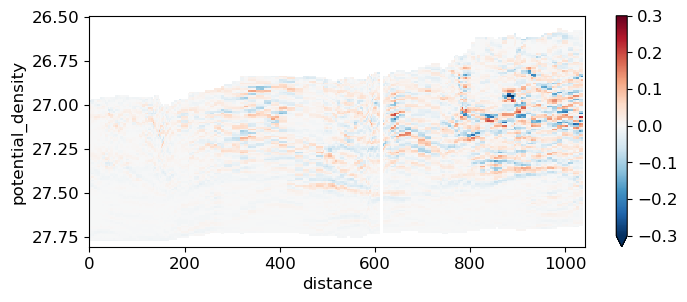

In [15]:
fig, ax = plt.subplots(figsize = (8,3))
(alpha[floatid]*theta_drho_drho).plot(x = 'distance', vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r')
ax.invert_yaxis()

#### $\alpha \theta_{\sigma\sigma}$ is over an order of magnitude larger than $\alpha_{\sigma} \theta_{\sigma}$

## DSC

In [10]:
DSC_concat_flt = ct.joinFloats(DSC_smooth, 'distance', new_dim = True)
dyn_m_concat = ct.joinFloats(dyn_m, 'distance', new_dim = True)
T_concat_dens = ct.joinFloats(T_dens, 'distance', new_dim = True)
mld_concat = ct.joinFloats(mld_on_d, 'distance', new_dim = True)

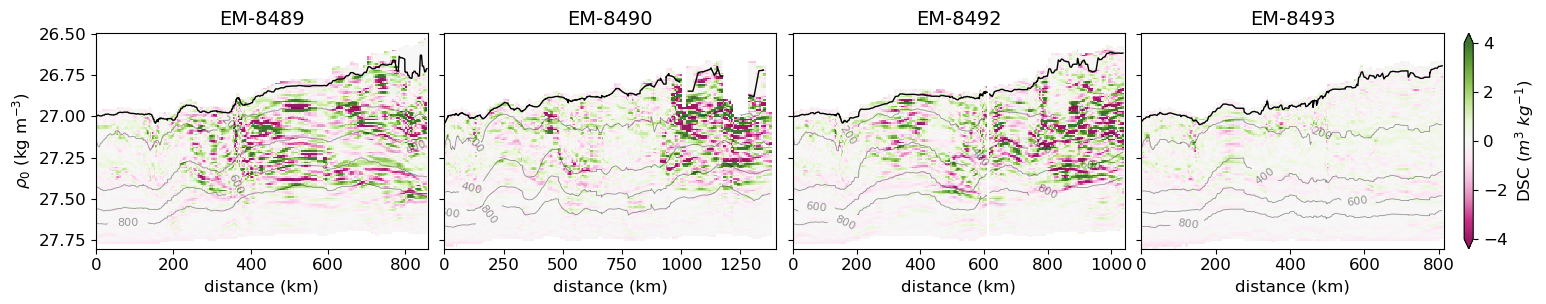

In [14]:
# DSC
fig, ax = plt.subplots(1, 4, sharey = True, figsize = (15, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:

    im = DSC_smooth[floatid].plot(ax = axs[i], x = 'distance', cmap = 'PiYG', vmin = -4, vmax = 4, 
                                   alpha = 0.9, add_colorbar = False)

    mld_on_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1, zorder = 4)
    
    CS = p_on_dens[floatid].plot.contour(ax = axs[i],
                                        x = 'distance', 
                                        levels = np.arange(0, 1000, 200),
                                        linewidths = 0.6, 
                                        colors = 'k', 
                                        alpha = 0.4)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.0f')

    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)

    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = "DSC ($m^{3}$ $kg^{-1}$)", extend = 'both')

In [17]:
floatid =  8489 #8492 #8490  #8493 
d1, d2 =   375,575 #700, 1100 #900,1350 #200,400
pd1, pd2 = 26.9, 27.4

i1 = np.where(ds[floatid].distance >= d1)[0][0]
i2 = np.where(ds[floatid].distance <= d2)[0][-1]+1

no_ticks = 4
tick_start = 8 #2 #7

t = ds[floatid].time[i1:i2].dt.strftime("%m-%d\nT%H:%M")
tickinterval = int(len(t)/no_ticks)
print(tickinterval)

10


In [18]:
## evenly grid in distance (3 km intervals)
dsc_even_grid = interp.even_dist_grid(DSC_smooth[floatid], 3)
pres_dens = interp.even_dist_grid(p_on_dens[floatid], 3)

dsc_sel = dsc_even_grid.sel(potential_density = slice(pd1, pd2), 
                        distance = slice(d1,d2))

Text(0.5, 1.0, 'EM-8489')

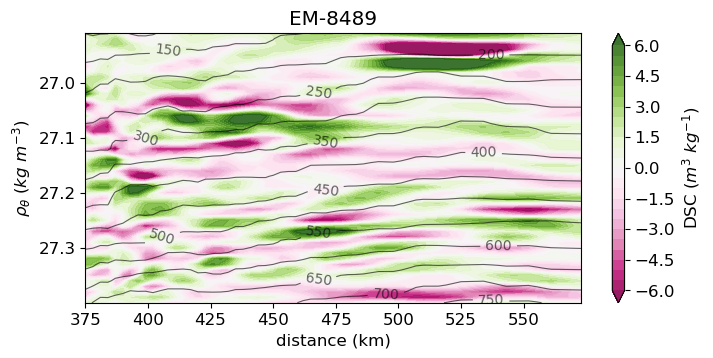

In [19]:
dsc_sel = dsc_even_grid.sel(potential_density = slice(pd1, pd2), 
                        distance = slice(d1,d2))

fig, ax = plt.subplots(figsize = (8,3.5))
dsc_sel.plot.contourf(x = 'distance', cmap = 'PiYG', 
                      cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)'),
                      levels = np.arange(-6,6.5, 0.5),
                       alpha = 0.9)

CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                x = 'distance', 
                                levels = np.arange(50, 800, 50),
                                linewidths = 0.8, 
                                colors = 'k', 
                                alpha = 0.6)
ax.clabel(CS, inline=True, fontsize=10, fmt = '%1.0f')

# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(ds[floatid].distance.sel(distance = slice(d1,d2)).distance[tick_start:-1:tickinterval])
# ax2.set_xticklabels(t.data[1:-1:tickinterval], multialignment='center', fontsize = 11)
# ax2.set_xlabel('time', loc = 'left')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

# settings.save_figure(fig, my_path, f'DSC_sel_EM-{floatid}.png', dpi = 600, pad = 0.2)

In [18]:
floatid = 8490
d1, d2 = 900,1350

pres_dens = interp.even_dist_grid(p_on_dens[floatid], 3)
dsc_even_grid = interp.even_dist_grid(DSC_smooth[floatid], 3)

Text(0.5, 1.0, 'EM-8490')

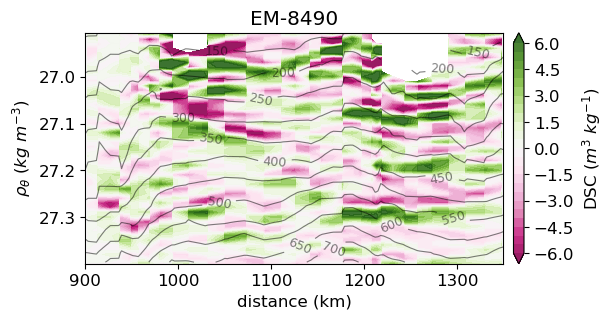

In [19]:
dsc_sel = DSC_smooth[floatid].sel(potential_density = slice(pd1, pd2), 
                        distance = slice(d1,d2))

fig, ax = plt.subplots(figsize = (6.5,3))
dsc_sel.plot.contourf(x = 'distance', cmap = 'PiYG', 
                      cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)', pad = 0.02),
                      levels = np.arange(-6,6.5, 0.5),
                       alpha = 0.9)

#p_on_dens[floatid]
CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                x = 'distance', 
                                levels = np.arange(50, 800, 50),
                                linewidths = 0.8, 
                                colors = 'k', 
                                alpha = 0.5)

ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

### Feature detection

In [15]:
floatid = 8489 #8492 #8490 #
d1, d2 =  375,575 #700,1100 #900,1350
pd1, pd2 = 26.9, 27.4

dataArray = DSC_smooth[floatid]

In [16]:
da_prof = xr.DataArray(dataArray.data, dims = ['profile', 'potential_density'], 
                       coords = dict(potential_density = ('potential_density', dataArray.potential_density.data), 
                                    profile = ('profile', np.arange(0, len(dataArray)))))

In [17]:
p_on_d_profile = xr.DataArray(p_on_dens[floatid].interp(potential_density = da_prof.potential_density).data, 
                              dims = da_prof.dims, coords = da_prof.coords)

In [18]:
prof1 = np.where(dataArray.distance <= d1)[0][-1]
prof2 = np.where(dataArray.distance >= d2)[0][0]
print(prof1, prof2)

156 198


Text(0.5, 1.0, 'EM-8489')

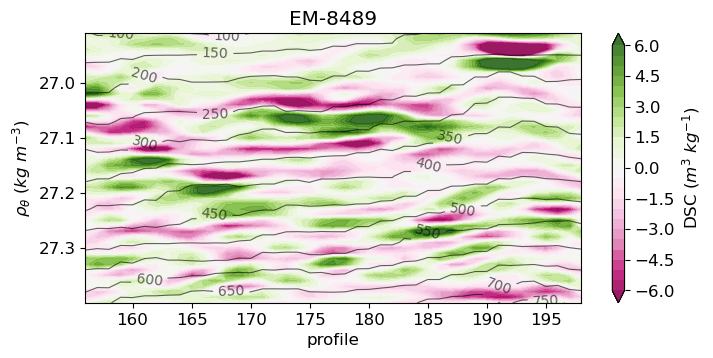

In [19]:
dsc_sel = da_prof.sel(potential_density = slice(pd1, pd2), 
                        profile = slice(prof1,prof2))

fig, ax = plt.subplots(figsize = (8,3.5))
dsc_sel.plot.contourf(x = 'profile', cmap = 'PiYG', 
                      cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)'),
                      levels = np.arange(-6,6.5, 0.5),
                       alpha = 0.9)

CS = p_on_d_profile.sel(potential_density = slice(pd1, pd2), 
                            profile = slice(prof1,prof2)).plot.contour(ax = ax, 
                                x = 'profile', 
                                levels = np.arange(50, 800, 50),
                                linewidths = 0.8, 
                                colors = 'k', 
                                alpha = 0.6)
ax.clabel(CS, inline=True, fontsize=10, fmt = '%1.0f')

ax.invert_yaxis()
ax.set_xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

Text(0.5, 1.0, 'EM-8489')

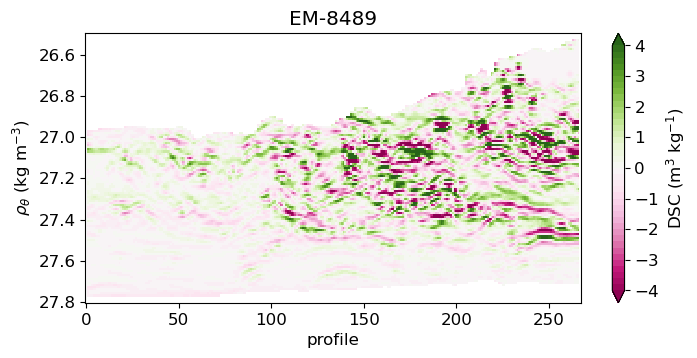

In [20]:
fig, ax = plt.subplots(figsize = (8,3.5))
da_prof.plot(x = 'profile', levels = np.arange(-4, 4.2, 0.2), cmap = 'PiYG',
                        cbar_kwargs = dict(label = 'DSC (m$^{3}$ kg$^{-1}$)'))

ax.invert_yaxis()

ax.set_ylabel(r'$\rho_{\theta}$ (kg m$^{-3}$)')
ax.set_xlabel('profile')
plt.title(f'EM-{floatid}')

# settings.save_figure(fig, my_path, 'DSC_8489.png', dpi = 600, pad = 0.2)

In [21]:
### Choice of DSC threshold value

nonan = np.where(~np.isnan(DSC_concat_flt.data.flatten()))
da_nonan_flt = DSC_concat_flt.data.flatten()[nonan]

print('90th percentile: ', np.percentile(abs(da_nonan_flt), 90, axis=0))

90th percentile:  1.6450179850187614


In [28]:
import src.feature_detection as fd

In [29]:
imp.reload(stats)

da = da_prof.transpose()
data = fd.FeatureDetection(da)
threshold_value = 2

# maxima
lower_val = threshold_value
upper_val = np.inf
fill_val = 999

# minima
lower_val = -np.inf
upper_val = -threshold_value
fill_val = -999

In [30]:
# minima
imp.reload(stats)

lower_val = -np.inf
upper_val = -threshold_value
fill_val = -999

contours_min = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)

# filter chains (minimum 10 data points)
filtered = data.filter_chains(contours_min, min_len = 10)
filtered_chains_min = list(np.asarray(contours_min)[filtered])

chain_values_min = data.get_chain_values(filtered_chains_min, fillvalue = fill_val)
chain_length_min = data.get_chain_lengths(chain_values_min, dataArray.distance)
chain_time_min = data.time_change(chain_values_min, ema[floatid].time)

# maxima
lower_val = threshold_value
upper_val = np.inf
fill_val = 999

contours_max = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)

# filter chains (minimum 10 data points)
filtered = data.filter_chains(contours_max, min_len = 10)
filtered_chains_max = list(np.asarray(contours_max)[filtered])

chain_values_max = data.get_chain_values(filtered_chains_max, fillvalue = fill_val)
chain_length_max = data.get_chain_lengths(chain_values_max, dataArray.distance)
chain_time_max = data.time_change(chain_values_max, ema[floatid].time)

C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'threshold: -2 m$^{3}$ kg$^{-1}$')

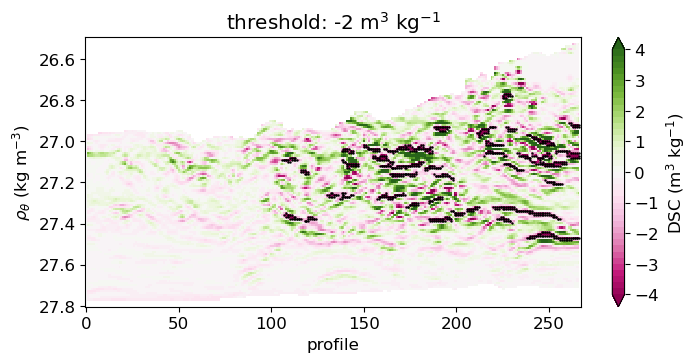

In [29]:
fig, ax = plt.subplots(figsize = (8,3.5))
da_prof.plot(x = 'profile', levels = np.arange(-4, 4.2, 0.2), cmap = 'PiYG', 
             cbar_kwargs = dict(label = 'DSC (m$^{3}$ kg$^{-1}$)'))

for chain in filtered_chains_min:
    for c in chain:
        prof, pd = c[0]
        plt.scatter(prof, dataArray.potential_density[pd], s = 0.5, c = 'k')

ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ (kg m$^{-3}$)')
plt.title(f'threshold: {-threshold_value}'+' m$^{3}$ kg$^{-1}$')

# settings.save_figure(fig, my_path, 'DSC_8489_minima_thresh_1.png', dpi = 600, pad = 0.2)

Text(0.5, 1.0, 'threshold: 2 m$^{3}$ kg$^{-1}$')

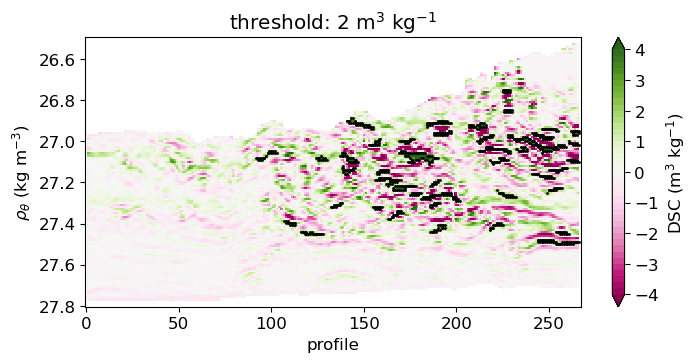

In [109]:
fig, ax = plt.subplots(figsize = (8,3.5))
da_prof.plot(x = 'profile', levels = np.arange(-4, 4.2, 0.2), cmap = 'PiYG', 
            cbar_kwargs = dict(label = 'DSC (m$^{3}$ kg$^{-1}$)'))

for chain in filtered_chains_max:
    for c in chain:
        prof, pd = c[0]
        plt.scatter(prof, dataArray.potential_density[pd], s = 1, c = 'k')

ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ (kg m$^{-3}$)')
plt.title(f'threshold: {threshold_value}'+' m$^{3}$ kg$^{-1}$')

# settings.save_figure(fig, my_path, 'DSC_8489_maxima_thresh_1.png', dpi = 600, pad = 0.2)

Text(0, 0.5, '$\\rho_{\\theta}$ ($kg$ $m^{-3})$')

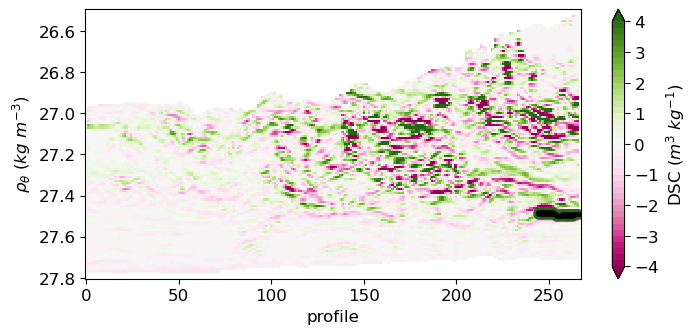

In [30]:
idx = 0

fig, ax = plt.subplots(figsize = (8,3.5))
da_prof.plot(x = 'profile', levels = np.arange(-4, 4.2, 0.2), cmap = 'PiYG', 
            cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)'))

for c in filtered_chains_max[idx]:
    prof, pd = c[0]
    plt.scatter(prof, dataArray.potential_density[pd], s = 5, c = 'k', zorder = 10)
    
for val in chain_values_max[idx]:
    plt.scatter(val.profile, val.potential_density, c = val, s = 40, cmap = 'PiYG', vmin = -2, vmax = 2)
    
    
ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')

Text(0.5, 1.0, 'chain index: 0')

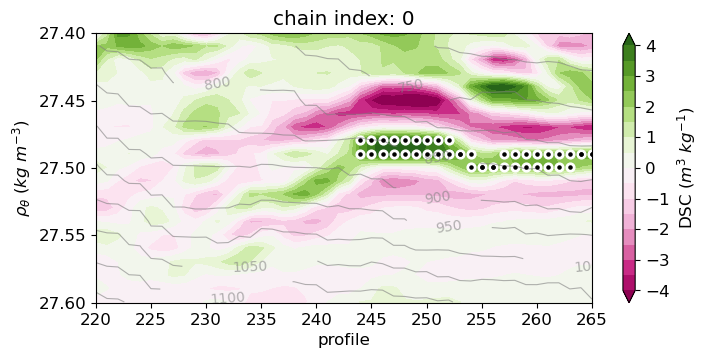

In [31]:
d1, d2 = 220, 265 #210,300
pd1, pd2 = 27.4, 27.6 #26.9, 27.2

fig, ax = plt.subplots(figsize = (8,3.5))
da_prof.plot.contourf(x = 'profile', levels = np.arange(-4, 4.5, 0.5), cmap = 'PiYG', 
                     cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)'))

CS = p_on_d_profile.sel(profile = slice(d1, d2), potential_density = slice(pd1, pd2)).plot.contour(x = 'profile', 
                                levels = np.arange(50, 1500, 50),
                                linewidths = 0.8, 
                                colors = 'grey', 
                                alpha = 0.6)

ax.clabel(CS, inline=True, fontsize=10, inline_spacing = -6, fmt = '%1.0f')

for c in filtered_chains_max[idx]:
    prof, pd = c[0]
    plt.scatter(prof, dataArray.potential_density[pd], s = 5, c = 'k', zorder = 10)
    
for val in chain_values_max[idx]:
    plt.scatter(val.profile, val.potential_density, c = 'w', s = 40)
    
plt.ylim(pd1, pd2)
plt.xlim(d1, d2)

ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'chain index: {idx}')

Text(0, 0.5, '$\\rho_{\\theta}$ ($kg$ $m^{-3})$')

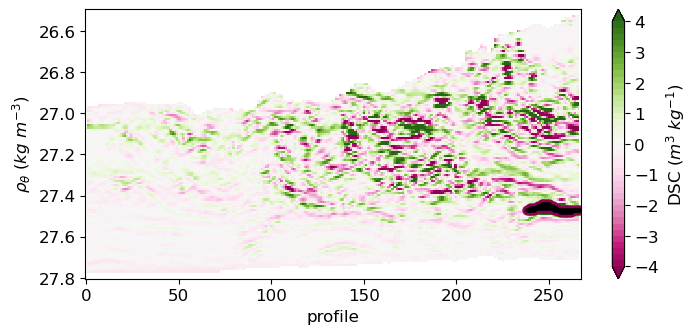

In [33]:
idx = 0

fig, ax = plt.subplots(figsize = (8,3.5))
da_prof.plot(x = 'profile', levels = np.arange(-4, 4.2, 0.2), cmap = 'PiYG', 
            cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)'))

for c in filtered_chains_min[idx]:
    prof, pd = c[0]
    plt.scatter(prof, dataArray.potential_density[pd], s = 5, c = 'k', zorder = 10)
    
for val in chain_values_min[idx]:
    plt.scatter(val.profile, val.potential_density, c = val, s = 40, cmap = 'PiYG', vmin = -2, vmax = 2)
    
    
ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')

Text(0.5, 1.0, 'chain index: 0')

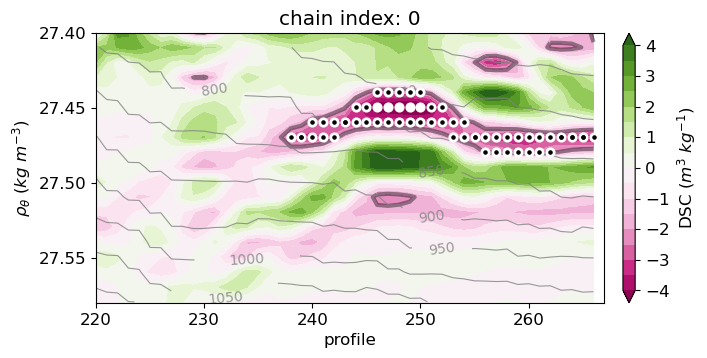

In [34]:
d1, d2 = 220, 267
pd1, pd2 = 27.4, 27.58

fig, ax = plt.subplots(figsize = (8,3.5))
da_prof.plot.contourf(x = 'profile', levels = np.arange(-4, 4.5, 0.5), cmap = 'PiYG', 
                     cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)', pad = 0.03))

da_prof.plot.contour(x = 'profile', levels = [-2], colors = 'k', linewidths = 3, linestyles = '-', 
                     add_colorbar = False, alpha = 0.4)

CS = p_on_d_profile.sel(profile = slice(d1, d2), potential_density = slice(pd1, pd2)).plot.contour(x = 'profile', 
                                levels = np.arange(50, 1500, 50),
                                linewidths = 0.8, 
                                colors = 'grey', 
                                alpha = 0.8)

ax.clabel(CS, fontsize=10, inline_spacing = -8, fmt = '%1.0f')

for c in filtered_chains_min[idx]:
    prof, pd = c[0]
    plt.scatter(prof, dataArray.potential_density[pd], s = 5, c = 'k', zorder = 10)
    
for val in chain_values_min[idx]:
    plt.scatter(val.profile, val.potential_density, c = 'w', s = 40, zorder = 9)
    
plt.ylim(pd1, pd2)
plt.xlim(d1, d2)
plt.yticks([27.4, 27.45, 27.5, 27.55])

ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'chain index: {idx}')

# plt.title(f'EM-{floatid}')

In [35]:
# settings.save_figure(fig, my_path, 'DSC_feature.png', dpi = 600, pad = 0.2)

### Height of chains

In [36]:
chain_df = data.create_dataframe(chain_values_min, pressure_on_dens = p_on_dens[floatid])

In [37]:
print(f'chain length: {chain_length_max[idx]:.2f} km')

chain length: 50.97 km


In [38]:
np.nanmean(chain_values_max[idx])

3.179794398365813

In [42]:
imp.reload(stats)
data = fd.FeatureDetection(da)

H_min = data.get_chain_heights(chain_values_min, p_on_dens[floatid])
H_max = data.get_chain_heights(chain_values_max, p_on_dens[floatid])

In [43]:
heights1 = H_min[H_min['chain']==idx]

mean: 19.85547515314028
median: 17.61912962611757
max: 39.94418537377305


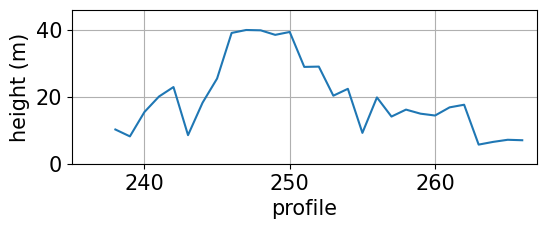

In [44]:
fig, ax = plt.subplots(figsize = (6, 2))
plt.plot(heights1['profile'], heights1['height'])
plt.ylabel('height (m)', fontsize = 15)
plt.xlabel('profile', fontsize = 15)
plt.ylim(0,46)
plt.xlim(235, d2)
plt.yticks([0,20,40], fontsize = 15)
plt.xticks([240,250,260], fontsize = 15)
plt.grid()

print(f'mean: {np.nanmean(heights1.height)}')
print(f'median: {np.nanmedian(heights1.height)}')
print(f'max: {np.nanmax(heights1.height)}')


# settings.save_figure(fig, my_path, 'DSC_feature_height.png', dpi = 600, pad = 0.2)

### Summary statistics

In [45]:
print(f'EM-{floatid}')

EM-8489


In [46]:
# Feature slopes with respect to isopycnals
d_slope_df_min = data.get_chain_slope(chain_values_min, pressure_on_dens = p_on_dens[floatid])
d_slope_df_max = data.get_chain_slope(chain_values_max, pressure_on_dens = p_on_dens[floatid])

In [47]:
# Feature slopes with respect to pressure
p_slope_df_min = data.get_chain_slope(chain_values_min, dz = 'pressure', pressure_on_dens = p_on_dens[floatid])
p_slope_df_max = data.get_chain_slope(chain_values_max, dz = 'pressure', pressure_on_dens = p_on_dens[floatid])

In [48]:
print('Maxima')
df_max = data.print_summary_stats(chain_values_max, chain_length_max, H_max, 
                                  chain_time = chain_time_max,
                                  chain_slope = p_slope_df_max)
df_max['extrema'] = 'maxima'
df_max['floatid'] = floatid

Maxima
printing overall statistics for features detected
no. features: 43
Feature length
mean L (km): 37.7 +/- 4.8
DSC value
mean value: 3.45 +/- 0.13
Height of features
mean H maxima: 11.31 +/- 0.65
Time change
mean dt: 39.23 +/- 3.45
slope (drho/dx)
mean avg slope: -1.3e-05 +/- 0.00019
max avg slope = 0.004661316981190745
min avg slope = -0.0024066002168536458


In [49]:
print('Minima')
df_min = data.print_summary_stats(chain_values_min, chain_length_min, H_min, 
                                  chain_time = chain_time_min,
                                 chain_slope = p_slope_df_min)
df_min['extrema'] = 'maxima'
df_min['floatid'] = floatid

Minima
printing overall statistics for features detected
no. features: 35
Feature length
mean L (km): 44.7 +/- 5.1
DSC value
mean value: -3.64 +/- 0.19
Height of features
mean H maxima: 11.53 +/- 0.82
Time change
mean dt: 44.89 +/- 5.34
slope (drho/dx)
mean avg slope: 0.00031 +/- 0.00016
max avg slope = 0.0027380212683316557
min avg slope = -0.001786741208953112


In [50]:
min(ema[floatid].time)

<xarray.DataArray 'time' ()>
array('2018-10-21T13:09:37.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-10-21T13:09:37
Attributes:
    standard_name:  time
    long_name:      time

In [51]:
import pandas as pd
imp.reload(stats)

all_data = pd.DataFrame(columns = df_max.columns)

for floatid in floatids:
    dataArray = DSC_smooth[floatid]

    da_prof = xr.DataArray(dataArray.data, dims = ['profile', 'potential_density'], 
                           coords = dict(potential_density = ('potential_density', dataArray.potential_density.data), 
                                        profile = ('profile', np.arange(0, len(dataArray)))))
    
    data = fd.FeatureDetection(da_prof.transpose())
    threshold_value = 2
    
    # MAXIMA
    lower_val = threshold_value
    upper_val = np.inf
    fill_val = 999

    contours_max = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)
    
    # filter chains (minimum 10 data points)
    filtered = data.filter_chains(contours_max, min_len = 10)
    filtered_chains_max = list(np.asarray(contours_max)[filtered])

    # layer characteristics
    chain_values_max = data.get_chain_values(filtered_chains_max, fillvalue = fill_val)
    chain_length_max = data.get_chain_lengths(chain_values_max, dataArray.distance)
    H_max = data.get_chain_heights(chain_values_max, p_on_dens[floatid])
    chain_time_max = data.time_change(chain_values_max, ema[floatid].time)
    
    # dataframe with lengths, mean DSC, and mean H for each feature in all triaxus tows
    df_max = data.print_summary_stats(chain_values_max, chain_length_max, H_max, chain_time = chain_time_max)
    df_max['extrema'] = 'maxima'
    df_max['floatid'] = floatid

    
    # MINIMA
    lower_val = -np.inf
    upper_val = -threshold_value
    
    contours_min = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)
    
    # filter chains (minimum 10 data points)
    filtered = data.filter_chains(contours_min, min_len = 10)
    filtered_chains_min = list(np.asarray(contours_min)[filtered])
    
    # layer characteristics
    chain_values_min = data.get_chain_values(filtered_chains_min, fillvalue = -fill_val)
    chain_length_min = data.get_chain_lengths(chain_values_min, dataArray.distance)
    H_min = data.get_chain_heights(chain_values_min, p_on_dens[floatid])
    chain_time_min = data.time_change(chain_values_min, ema[floatid].time)
    
    # dataframe with lengths, mean DSC, and mean H for each feature in all triaxus tows
    df_min = data.print_summary_stats(chain_values_min, chain_length_min, H_min, chain_time = chain_time_min)
    df_min['extrema'] = 'minima'
    df_min['floatid'] = floatid
    
    df = df_min.append(df_max)
    all_data = all_data.append(df)


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 43
Feature length
mean L (km): 37.7 +/- 4.8
DSC value
mean value: 3.45 +/- 0.13
Height of features
mean H maxima: 11.31 +/- 0.65
Time change
mean dt: 39.23 +/- 3.45


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 35
Feature length
mean L (km): 44.7 +/- 5.1
DSC value
mean value: -3.64 +/- 0.19
Height of features
mean H maxima: 11.53 +/- 0.82
Time change
mean dt: 44.89 +/- 5.34


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 21
Feature length
mean L (km): 79.1 +/- 12.6
DSC value
mean value: 3.77 +/- 0.27
Height of features
mean H maxima: 14.15 +/- 0.95
Time change
mean dt: 44.33 +/- 6.81


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 23
Feature length
mean L (km): 69.4 +/- 9.9
DSC value
mean value: -4.15 +/- 0.26
Height of features
mean H maxima: 13.61 +/- 1.71
Time change
mean dt: 40.17 +/- 4.80


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 44
Feature length
mean L (km): 45.9 +/- 5.4
DSC value
mean value: 3.33 +/- 0.11
Height of features
mean H maxima: 10.23 +/- 0.59
Time change
mean dt: 42.91 +/- 3.95


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 37
Feature length
mean L (km): 48.7 +/- 5.2
DSC value
mean value: -3.67 +/- 0.17
Height of features
mean H maxima: 13.31 +/- 0.81
Time change
mean dt: 44.27 +/- 4.82
printing overall statistics for features detected
no. features: 1
Feature length
mean L (km): 9.3 +/- nan
DSC value
mean value: 2.96 +/- nan
Height of features
mean H maxima: 7.51 +/- nan
Time change
mean dt: 16.00 +/- nan
printing overall statistics for features detected
no. features: 0
Feature length
mean L (km): nan +/- nan
DSC value
mean value: nan +/- nan
Height of features
mean H maxima: nan +/- nan


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [47]:
all_data

chain_idx     length  mean_height  mean_value   time extrema floatid
0          0  68.293580    19.855475   -3.161020  113.0  minima    8489
1          1  44.985801    10.255265   -2.620209   31.0  minima    8489
2          2  95.925693    17.164755   -3.953850   48.0  minima    8489
3          3  21.287979    10.719796   -2.561223   24.0  minima    8489
4          4  29.886644    16.156494   -3.211212   32.0  minima    8489
..       ...        ...          ...         ...    ...     ...     ...
40        40  34.151375     7.786690    2.773142   24.0  maxima    8492
41        41  80.815787     2.407447    2.573696   64.0  maxima    8492
42        42  25.908924     8.207256    3.193636   23.0  maxima    8492
43        43  18.743355     7.290315    3.116709   16.0  maxima    8492
0          0   9.284677     7.508132    2.957798   16.0  maxima    8493

[204 rows x 7 columns]

In [48]:
all_data[all_data['extrema'] == 'maxima']

chain_idx     length  mean_height  mean_value  time extrema floatid
0          0  50.970808    15.721995    3.179794  88.0  maxima    8489
1          1  18.848145    11.848077    3.221438  30.0  maxima    8489
2          2  40.726408    10.524035    2.877966  49.0  maxima    8489
3          3  63.341433    21.513546    2.710956  32.0  maxima    8489
4          4  37.270749    11.895623    2.462129  31.0  maxima    8489
..       ...        ...          ...         ...   ...     ...     ...
40        40  34.151375     7.786690    2.773142  24.0  maxima    8492
41        41  80.815787     2.407447    2.573696  64.0  maxima    8492
42        42  25.908924     8.207256    3.193636  23.0  maxima    8492
43        43  18.743355     7.290315    3.116709  16.0  maxima    8492
0          0   9.284677     7.508132    2.957798  16.0  maxima    8493

[109 rows x 7 columns]

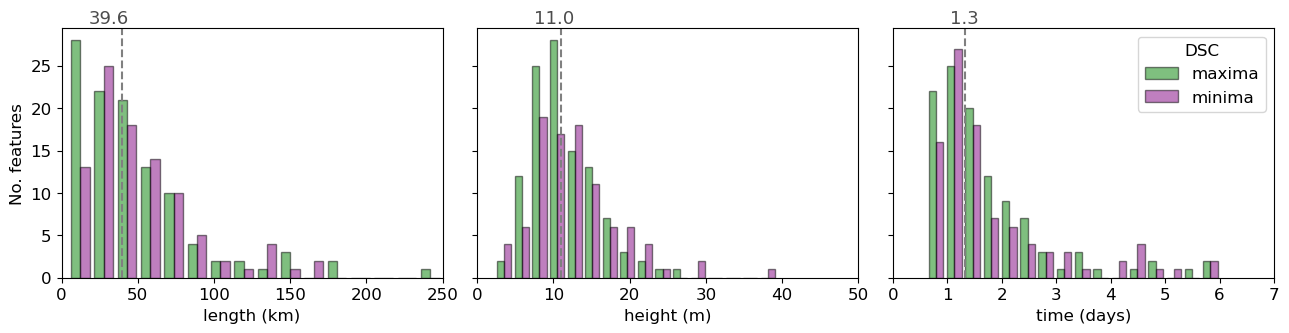

In [47]:
minima = all_data['extrema'] == 'minima'
maxima = all_data['extrema'] == 'maxima'
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (13,3.5))

# Length
n, bins, patches = ax1.hist(x=[all_data['length'][maxima], all_data['length'][minima]], 
                            bins = 16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)


median = all_data['length'].median()
ax1.axvline(x = median, linestyle = '--', c = 'grey')
ax1.text(0.07, 1.02, f'{median:.1f}', transform = ax1.transAxes, c = 'k', alpha = 0.7, fontsize = 13)
ax1.set_xlabel('length (km)')
ax1.set_ylabel('No. features')
ax1.set_xlim(0, 250)

# Height
n, bins, patches = ax2.hist(x=[all_data['mean_height'][maxima], all_data['mean_height'][minima]], 
                            bins = 16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)

median = all_data['mean_height'].median()
ax2.axvline(x = median, linestyle = '--', c = 'grey')
ax2.text(0.15, 1.02, f'{median:.1f}', transform = ax2.transAxes, c = 'k', alpha = 0.7, fontsize = 13)
ax2.set_xlabel('height (m)')
ax2.set_xlim(0, 50)

# Time 
n, bins, patches = ax3.hist(x=[all_data['time'][maxima]/24, all_data['time'][minima]/24], 
                            bins = 16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)


plt.legend(['maxima', 'minima'], title = 'DSC', fontsize = 12, loc = 'upper right')

median = all_data['time'].median()/24
ax3.axvline(x = median, linestyle = '--', c = 'grey')
ax3.text(0.15, 1.02, f'{median:.1f}', transform = ax3.transAxes, c = 'k', alpha = 0.7, fontsize = 13)
ax3.set_xlabel('time (days)')
ax3.set_xlim(0,7)


plt.tight_layout(w_pad = 0.8)

In [48]:
# settings.save_figure(fig, my_path, 'Float_histograms.png', dpi = 600, pad = 0.2)

#### Float data:

| Threshold value (m$^{3}$ kg$^{-1}$) | no.features | median length (km) | median height (m) | median time (days) |
| --- | --- | --- | --- | --- |
| 1.2 | 378 | 40.6 | 11.8 | 1.5 |
| 1.65 | 261 | 40.5 | 11.1 | 1.6 |
| 1.8 | 235 | 39.9 | 11.4 | 1.6 |
| 2.0 | 204 | 39.6 | 11.0 | 1.3 |

### Correlation between intrusion scales (e.g. length) and DSC magnitude / current speed

Pearsons corr: 0.247, p-value: 0.000378
Pearsons corr: 0.206, p-value: 0.0031


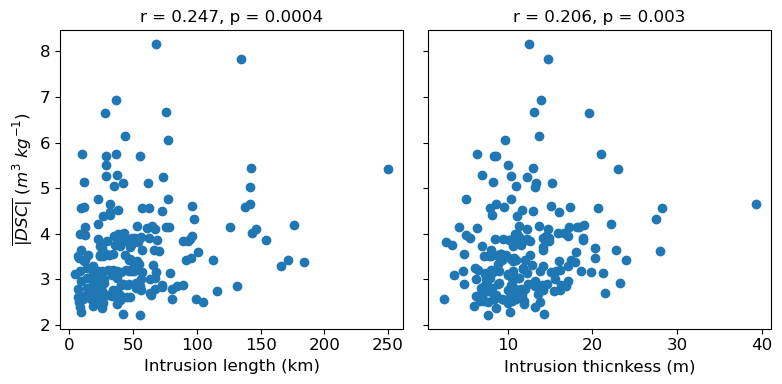

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

x = all_data.length
y = abs(all_data.mean_value)
ax1.scatter(x, y)
ax1.set_xlabel('Intrusion length (km)')
ax1.set_ylabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')
r, p = stats.pearsons(x, y, print_info = True)
ax1.set_title(f'r = {r:.3}, p = {p:.1}', fontsize = 12)

x = all_data.mean_height
y = abs(all_data.mean_value)
ax2.scatter(x, y)
ax2.set_xlabel('Intrusion thicnkess (m)')
r, p = stats.pearsons(x, y, print_info = True)
ax2.set_title(f'r = {r:.3}, p = {p:.1}', fontsize = 12)

plt.tight_layout(w_pad = 1.2)

In [138]:
speed_dens = {}
u_rot_dens = {}
for floatid in [8489, 8492, 8493]:
    speed = calc.speed(ds[floatid].u_abs, ds[floatid].v_abs)
    u_rot_dens[floatid] = interp.varToDens(abs(ds[floatid].u_rot), pdens = dens[floatid], dens_interval = 0.01, by_dist = True, rs = False)
    speed_dens[floatid] = interp.varToDens(speed, pdens = dens[floatid], dens_interval = 0.01, by_dist = True, rs = False)

In [139]:
new_df = df_max.copy()

In [140]:
new_df['speed'] = 0.1

In [141]:
imp.reload(stats)

data_3_flts = pd.DataFrame(columns = new_df.columns)

for floatid in [8489, 8492, 8493]:
    dataArray = DSC_smooth[floatid]

    da_prof = xr.DataArray(dataArray.data, dims = ['profile', 'potential_density'], 
                           coords = dict(potential_density = ('potential_density', dataArray.potential_density.data), 
                                        profile = ('profile', np.arange(0, len(dataArray)))))
    
    data = fd.FeatureDetection(da_prof.transpose())
    threshold_value = 2
    
    # MAXIMA
    lower_val = threshold_value
    upper_val = np.inf
    fill_val = 999

    contours_max = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)
    
    # filter chains (minimum 10 data points)
    filtered = data.filter_chains(contours_max, min_len = 10)
    filtered_chains_max = list(np.asarray(contours_max)[filtered])

    # layer characteristics
    chain_values_max = data.get_chain_values(filtered_chains_max, fillvalue = fill_val)
    chain_length_max = data.get_chain_lengths(chain_values_max, dataArray.distance)
    H_max = data.get_chain_heights(chain_values_max, p_on_dens[floatid])
    chain_time_max = data.time_change(chain_values_max, ema[floatid].time)
    chain_speed_max = data.get_chain_current_speed(chain_values_max, u_rot_dens[floatid])
    
    # dataframe with lengths, mean DSC, and mean H for each feature
    new_df_max = data.print_summary_stats(chain_values_max, chain_length_max, H_max, chain_time = chain_time_max)
    new_df_max['extrema'] = 'maxima'
    new_df_max['floatid'] = floatid
    new_df_max['speed'] = chain_speed_max.mean_speed
    
    # MINIMA
    lower_val = -np.inf
    upper_val = -threshold_value
    
    contours_min = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)
    
    # filter chains (minimum 10 data points)
    filtered = data.filter_chains(contours_min, min_len = 10)
    filtered_chains_min = list(np.asarray(contours_min)[filtered])
    
    # layer characteristics
    chain_values_min = data.get_chain_values(filtered_chains_min, fillvalue = -fill_val)
    chain_length_min = data.get_chain_lengths(chain_values_min, dataArray.distance)
    H_min = data.get_chain_heights(chain_values_min, p_on_dens[floatid])
    chain_time_min = data.time_change(chain_values_min, ema[floatid].time)
    chain_speed_min = data.get_chain_current_speed(chain_values_min, u_rot_dens[floatid])
    
    # dataframe with lengths, mean DSC, and mean H for each feature
    new_df_min = data.print_summary_stats(chain_values_min, chain_length_min, H_min, chain_time = chain_time_min)
    new_df_min['extrema'] = 'minima'
    new_df_min['floatid'] = floatid
    new_df_min['speed'] = chain_speed_min.mean_speed
    
    new_df = new_df_min.append(new_df_max)
    data_3_flts = data_3_flts.append(new_df)
    

C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 43
Feature length
mean L (km): 37.7 +/- 4.8
DSC value
mean value: 3.45 +/- 0.13
Height of features
mean H maxima: 11.31 +/- 0.65
Time change
mean dt: 39.23 +/- 3.45


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 35
Feature length
mean L (km): 44.7 +/- 5.1
DSC value
mean value: -3.64 +/- 0.19
Height of features
mean H maxima: 11.53 +/- 0.82
Time change
mean dt: 44.89 +/- 5.34


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 44
Feature length
mean L (km): 45.9 +/- 5.4
DSC value
mean value: 3.33 +/- 0.11
Height of features
mean H maxima: 10.23 +/- 0.59
Time change
mean dt: 42.91 +/- 3.95


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 37
Feature length
mean L (km): 48.7 +/- 5.2
DSC value
mean value: -3.67 +/- 0.17
Height of features
mean H maxima: 13.31 +/- 0.81
Time change
mean dt: 44.27 +/- 4.82
printing overall statistics for features detected
no. features: 1
Feature length
mean L (km): 9.3 +/- nan
DSC value
mean value: 2.96 +/- nan
Height of features
mean H maxima: 7.51 +/- nan
Time change
mean dt: 16.00 +/- nan
printing overall statistics for features detected
no. features: 0
Feature length
mean L (km): nan +/- nan
DSC value
mean value: nan +/- nan
Height of features
mean H maxima: nan +/- nan


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [142]:
data_3_flts = data_3_flts.dropna()

In [143]:
data_3_flts

chain_idx     length  mean_height  mean_value   time extrema floatid  \
0          0  68.293580    19.855475   -3.161020  113.0  minima    8489   
1          1  44.985801    10.255265   -2.620209   31.0  minima    8489   
2          2  95.925693    17.164755   -3.953850   48.0  minima    8489   
3          3  21.287979    10.719796   -2.561223   24.0  minima    8489   
4          4  29.886644    16.156494   -3.211212   32.0  minima    8489   
..       ...        ...          ...         ...    ...     ...     ...   
39        39  42.007576    14.681612    2.891626   22.0  maxima    8492   
40        40  34.151375     7.786690    2.773142   24.0  maxima    8492   
42        42  25.908924     8.207256    3.193636   23.0  maxima    8492   
43        43  18.743355     7.290315    3.116709   16.0  maxima    8492   
0          0   9.284677     7.508132    2.957798   16.0  maxima    8493   

       speed  
0   0.153826  
1   0.414913  
2   0.573971  
3   0.357374  
4   0.325531  
..       ...  
39  1.136368  
40  0.671259  
42  0.663006  
43  0.357205  
0   0.278598  

[139 rows x 8 columns]

Pearsons corr: 0.560, p-value: 7.79e-13
Pearsons corr: 0.215, p-value: 0.0109


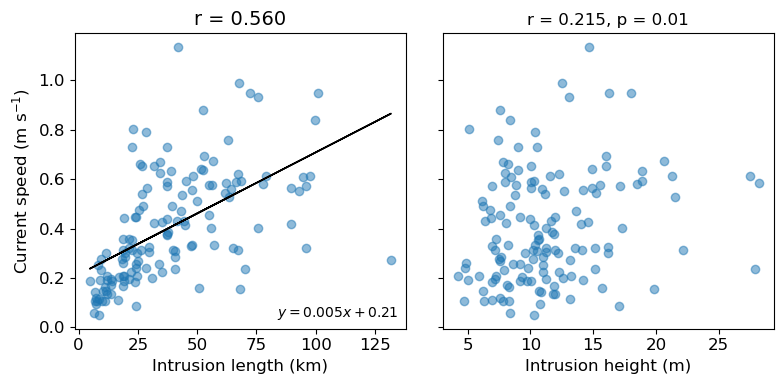

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

x = data_3_flts.length.values
y = data_3_flts.speed.values
ax1.scatter(x, y, alpha = 0.5)
ax1.set_xlabel('Intrusion length (km)')
ax1.set_ylabel('Current speed (m s$^{-1}$)')
r, p = stats.pearsons(x, y, print_info = True)
ax1.set_title(f'r = {r:.3f}', fontsize = 14)

#linear fit
nonans = np.where(~np.isnan(x*y))[0]
m, b = np.polyfit(x[nonans], y[nonans], 1)
yfit = [(m * xi) + b for xi in x[nonans]]
ax1.plot(x[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.3f}x + {b:.2f}$'
ax1.text(0.61, 0.04, line, transform = ax1.transAxes, fontsize = 10)

# seconds = length (m) / speed (m/s) then convert to hours (/3600)
timescale = (x[nonans]*1000/yfit)/3600

x = data_3_flts.mean_height
y = data_3_flts.speed
ax2.scatter(x, y, alpha = 0.5)
ax2.set_xlabel('Intrusion height (m)')
r, p = stats.pearsons(x, y, print_info = True)
ax2.set_title(f'r = {r:.3}, p = {p:.1}', fontsize = 12)

plt.tight_layout(w_pad = 1.2)

Pearsons corr: 0.560, p-value: 7.94e-13
Pearsons corr: 0.214, p-value: 0.0114


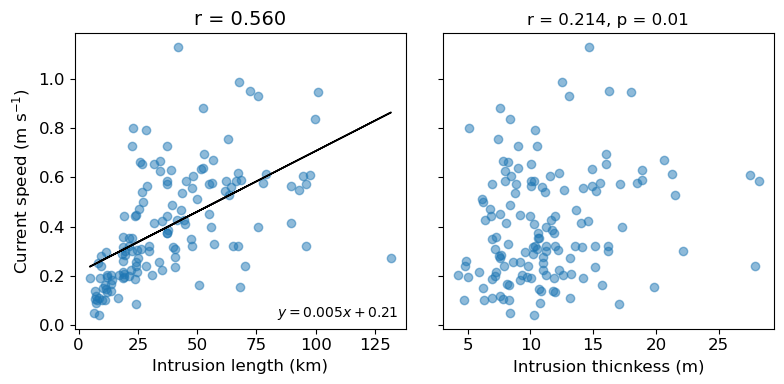

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

x = data_3_flts.length.values
y = data_3_flts.speed.values
ax1.scatter(x, y, alpha = 0.5)
ax1.set_xlabel('Intrusion length (km)')
ax1.set_ylabel('Current speed (m s$^{-1}$)')
r, p = stats.pearsons(x, y, print_info = True)
ax1.set_title(f'r = {r:.3f}', fontsize = 14)

#linear fit
nonans = np.where(~np.isnan(x*y))[0]
m, b = np.polyfit(x[nonans], y[nonans], 1)
yfit = [(m * xi) + b for xi in x[nonans]]
ax1.plot(x[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.3f}x + {b:.2f}$'
ax1.text(0.61, 0.04, line, transform = ax1.transAxes, fontsize = 10)

# seconds = length (m) / speed (m/s) then convert to hours (/3600)
timescale = (x[nonans]*1000/yfit)/3600

x = data_3_flts.mean_height
y = data_3_flts.speed
ax2.scatter(x, y, alpha = 0.5)
ax2.set_xlabel('Intrusion thicnkess (m)')
r, p = stats.pearsons(x, y, print_info = True)
ax2.set_title(f'r = {r:.3}, p = {p:.1}', fontsize = 12)

plt.tight_layout(w_pad = 1.2)

In [113]:
# settings.save_figure(fig, my_path, 'speed_vs_length.png', dpi = 600, pad = 0.2)

In [122]:
m

0.004929745944210759

In [125]:
x = 50
y = 0.005*x + 0.21

In [129]:
x*1000/y/3600

30.19323671497585

In [97]:
np.nanmax(timescale)

42.3878256787603

In [1]:
# minima = data_3_flts['extrema'] == 'minima'
# maxima = data_3_flts['extrema'] == 'maxima'
    
# fig, ax1 = plt.subplots(figsize = (6,4))

# # Length
# n, bins, patches = ax1.hist(x=[data_3_flts['length'][maxima], data_3_flts['length'][minima]], 
#                             bins = 16, edgecolor='black', color = ['green', 'purple'],
#                             alpha = 0.5, stacked = False)


# median = data_3_flts['length'].median()
# ax1.axvline(x = median, linestyle = '--', c = 'grey')
# ax1.text(0.18, 1.02, f'{median:.1f}', transform = ax1.transAxes, c = 'k', alpha = 0.7, fontsize = 13)
# ax1.set_xlabel('length (km)')
# ax1.set_ylabel('No. features')
# ax1.set_xlim(0, 150)


# speeds = xr.DataArray(data_3_flts.speed.values, dims = 'length', 
#              coords = dict(length = ('length', data_3_flts.length.values)))

# mean_speed = speeds.groupby_bins('length', bins =bins).mean()
# bin_mid_points = (bins-(np.gradient(bins)[0]/2))[1:]


# ax2 = ax1.twinx()
# ax2.plot(bin_mid_points, mean_speed,'-o', c = 'tab:blue', alpha = 0.8)
# ax2.set_ylabel('current speed (m/s)', c = 'tab:blue')

Pearsons corr: 0.284, p-value: 0.000718
Pearsons corr: 0.214, p-value: 0.0114


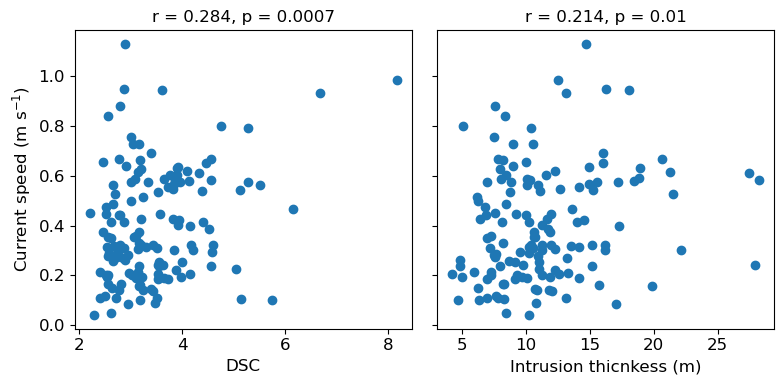

In [156]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

x = abs(data_3_flts.mean_value)
y = data_3_flts.speed
ax1.scatter(x, y)
ax1.set_xlabel('DSC')
ax1.set_ylabel('Current speed (m s$^{-1}$)')
r, p = stats.pearsons(x, y, print_info = True)
ax1.set_title(f'r = {r:.3}, p = {p:.1}', fontsize = 12)

x = data_3_flts.mean_height
y = data_3_flts.speed
ax2.scatter(x, y)
ax2.set_xlabel('Intrusion thicnkess (m)')
r, p = stats.pearsons(x, y, print_info = True)
ax2.set_title(f'r = {r:.3}, p = {p:.1}', fontsize = 12)

plt.tight_layout(w_pad = 1.2)

## TRIAXUS 

In [49]:
# Triaxus
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'triaxus')
folder = 'in2018_v05CtdAvgTriaxus_VerticalCasts_nc'

tow_list = ['01_002', '02_002', '02_005', '03_003', '04_002', '04_003', 
       '06_002', '07_002', '08_002', '08_003', '09_002', '09_003']

triaxus_cast = imports.triaxus_data(datadir, tow_list, folder)

In [50]:
lst = ['01_002', '02_002', '03_003', '04_002', '04_003', 
       '06_002', '07_002', '08_002']

d = {}

for tow in lst:
    triaxus_vertical_cast = triaxus_cast[tow]
    d[tow] = settings.distanceAsCoord(triaxus_vertical_cast, xdim = 'time')
    d[tow]['pdens'] = calc.potentialDensity(d[tow].pressure, d[tow].salinity, d[tow].temperature)
    

In [51]:
dens_levels = np.arange(26.6,27.5,0.04)

In [52]:
levs = [-125, -90, -45, 45, 90, 125]

DSC = {}
T_dens = {}
S_dens = {}
P_on_d = {}
DSC_smooth = {}
mld = {}

for tow in lst:
    S = d[tow].salinity
    T = d[tow].temperature
    
    mld[tow] = calc.MLD(d[tow].pdens, criteria = 0.02, pref = 10)
    
    DSC[tow], T_dens[tow], S_dens[tow] = calc.DSC(T, S, pdens = d[tow].pdens, x_smooth = False)
    
    DSC_smooth[tow] = DSC[tow].rolling(distance = 3, center = True, min_periods = 2).mean()
    
    if tow == '02_002':
        ind = [24, 25]
        DSC_smooth[tow][ind] = np.nan
        
    pressure = xr.DataArray(np.tile(T.pressure, (len(T.distance), 1)), dims = T.dims, coords = T.coords)
    P_on_d[tow] = interp.to_pdens_grid(pressure, d[tow].pdens, zdim = 'pressure', dens_interval = 0.01)
    

interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid


Text(0.5, 1.0, 'tow 4')

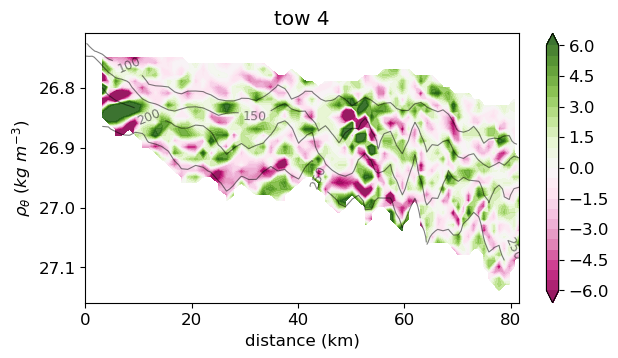

In [53]:
i = 3
tow = lst[i]

fig, ax = plt.subplots(figsize = (7,3.5))
DSC[tow].plot.contourf(x = 'distance', cmap = 'PiYG', 
                                       levels = np.arange(-6,6.5, 0.5),
                                       alpha = 0.9)

CS = P_on_d[tow].plot.contour(ax = ax, x = 'distance', 
                                        levels = np.arange(100, 350, 50), 
                                        linewidths = 0.8, 
                                        colors = 'k', 
                                        alpha = 0.5)

ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax.invert_yaxis()
plt.xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'tow {i+1}')

In [54]:
dataArray = DSC_smooth[tow]

da_prof = xr.DataArray(dataArray.data, dims = ['profile', 'potential_density'], 
                       coords = dict(potential_density = ('potential_density', dataArray.potential_density.data), 
                                     profile = ('profile', np.arange(0, len(dataArray)))))


P_on_d_prof = xr.DataArray(P_on_d[tow].data, dims = ['profile', 'potential_density'], 
                       coords = dict(potential_density = ('potential_density', P_on_d[tow].potential_density.data), 
                                     profile = ('profile', np.arange(0, len(P_on_d[tow])))))

Text(0.5, 1.0, 'tow 4')

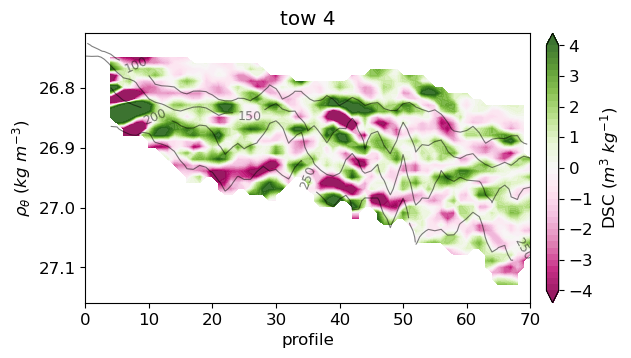

In [55]:
fig, ax = plt.subplots(figsize = (7,3.5))
da_prof.plot.contourf(x = 'profile', cmap = 'PiYG', alpha = 0.9,
                                     levels = np.arange(-4,4.2, 0.2), 
                                     cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)', pad = 0.03))

CS = P_on_d_prof.plot.contour(ax = ax, x = 'profile', 
                                        levels = np.arange(100, 350, 50), 
                                        linewidths = 0.8, 
                                        colors = 'k', 
                                        alpha = 0.5)

ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'tow {i+1}')

C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'threshold: -1.2 m$^{3}$ kg$^{-1}$')

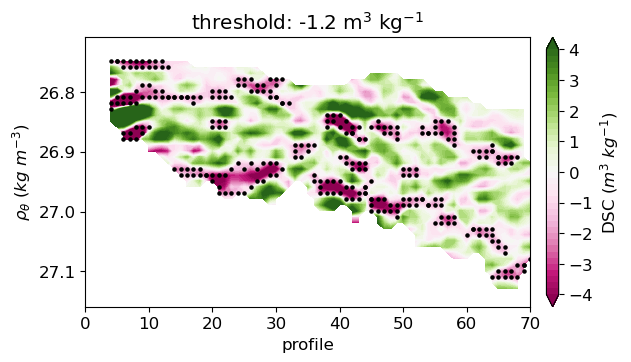

In [56]:
# minima
imp.reload(stats)

da = da_prof.transpose()
data = stats.FeatureDetection(da)
threshold_value = 1.2

lower_val = -np.inf
upper_val = -threshold_value
fill_val = -999

contours_min = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)
filtered = data.filter_chains(contours_min, min_len = 6)
filtered_chains_min = list(np.asarray(contours_min)[filtered])

fig, ax = plt.subplots(figsize = (7,3.5))
da_prof.plot.contourf(x = 'profile', cmap = 'PiYG', 
                                       levels = np.arange(-4,4.2, 0.2),
            cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)', pad = 0.03))

for chain in filtered_chains_min:
    for c in chain:
        prof, pd = c[0]
        plt.scatter(prof, dataArray.potential_density[pd], s = 5, c = 'k')

ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'threshold: {-threshold_value}'+' m$^{3}$ kg$^{-1}$')

In [57]:
chain_values_min = data.get_chain_values(filtered_chains_min, fillvalue = fill_val)
chain_length_min = data.get_chain_lengths(chain_values_min, dataArray.distance)

Text(0.5, 1.0, 'threshold: 1.2 m$^{3}$ kg$^{-1}$')

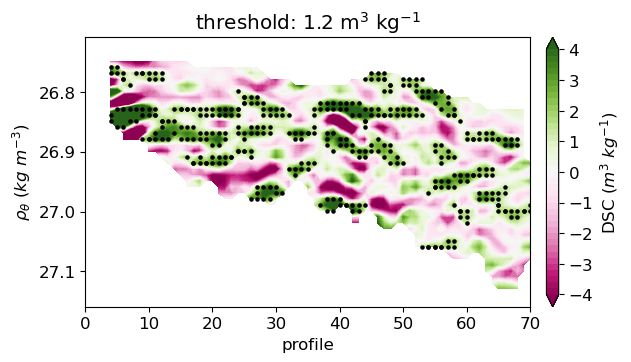

In [58]:
# maxima
lower_val = threshold_value
upper_val = np.inf
fill_val = 999

contours_max = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)
filtered = data.filter_chains(contours_max, min_len = 6)
filtered_chains_max = list(np.asarray(contours_max)[filtered])

fig, ax = plt.subplots(figsize = (7,3.5))
da_prof.plot.contourf(x = 'profile', cmap = 'PiYG', levels = np.arange(-4,4.2, 0.2), 
            cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)', pad = 0.03))

for chain in filtered_chains_max:
    for c in chain:
        prof, pd = c[0]
        plt.scatter(prof, dataArray.potential_density[pd], s = 5, c = 'k')

ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'threshold: {threshold_value}'+' m$^{3}$ kg$^{-1}$')

In [59]:
chain_values_max = data.get_chain_values(filtered_chains_max, fillvalue = fill_val)
chain_length_max = data.get_chain_lengths(chain_values_max, dataArray.distance)

In [60]:
p_on_d_profile = xr.DataArray(P_on_d[tow].interp(potential_density = da_prof.potential_density).data, 
                              dims = da_prof.dims, coords = da_prof.coords)

Text(0.5, 1.0, 'tow 4')

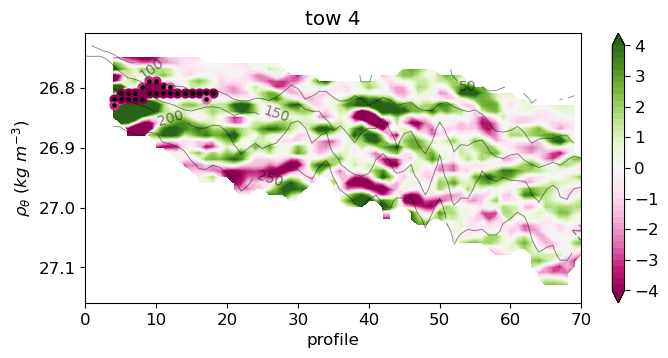

In [61]:
idx = 15

chains = filtered_chains_min
chain_values = chain_values_min


fig, ax = plt.subplots(figsize = (8,3.5))
da_prof.plot.contourf(x = 'profile', levels = np.arange(-4, 4.2, 0.2), cmap = 'PiYG')

for c in chains[idx]:
    prof, pd = c[0]
    plt.scatter(prof, dataArray.potential_density[pd], s = 5, c = 'k', zorder = 10)
    
for val in chain_values[idx]:
    plt.scatter(val.profile, val.potential_density, c = val, s = 40, cmap = 'PiYG', vmin = -2, vmax = 2)
    
CS = p_on_d_profile.plot.contour(x = 'profile', 
                                levels = np.arange(0, 350, 50),
                                linewidths = 0.6, 
                                colors = 'k', 
                                alpha = 0.5)

ax.clabel(CS, inline=True, fontsize=10, fmt = '%1.0f')
    
ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'tow {i+1}')

Text(0.5, 1.0, 'Tow 4 chain index: 15')

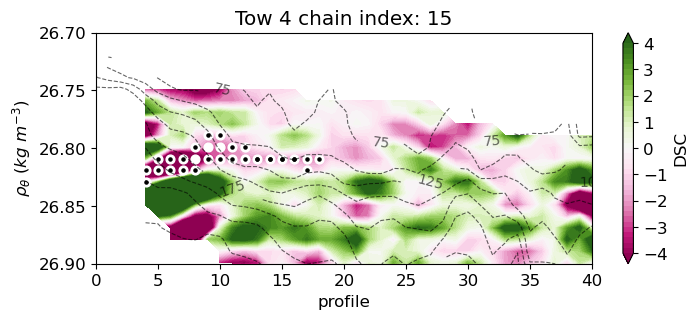

In [62]:
prof1, prof2 = 0, 40
pd1, pd2 = 26.7, 26.9

fig, ax = plt.subplots(figsize = (8,3))
da_prof.plot.contourf(x = 'profile', levels = np.arange(-4, 4.2, 0.2), cmap = 'PiYG', cbar_kwargs  = dict(label = 'DSC'))

CS = p_on_d_profile.plot.contour(x = 'profile', 
                                levels = np.arange(0, 325, 25),
                                linewidths = 0.8, 
                                colors = 'k', 
                                linestyles= '--',
                                alpha = 0.6)

ax.clabel(CS, inline=True, fontsize=10, fmt = '%1.0f')

for c in chains[idx]:
    prof, pd = c[0]
    plt.scatter(prof, dataArray.potential_density[pd], s = 5, c = 'k', zorder = 10)
    
for val in chain_values[idx]:
    plt.scatter(val.profile, val.potential_density, c = 'w', s = 40)
    
# plt.scatter(slopes_min[idx].profile, slopes_min[idx].density, zorder = 6)
    
plt.ylim(pd1, pd2)
plt.xlim(prof1, prof2)

ax.invert_yaxis()
plt.xlabel('profile')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'Tow {i+1} chain index: {idx}')

### Chain height

In [63]:
H_minima = data.get_chain_heights(chain_values_min, P_on_d[tow])
H_maxima = data.get_chain_heights(chain_values_max, P_on_d[tow])

In [64]:
heights_idx = H_minima[H_minima['chain']==idx]

mean: 12.178299494364742
max: 26.48999816458158


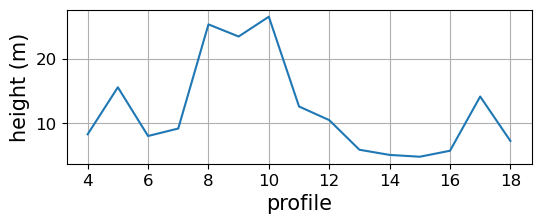

In [65]:
fig, ax = plt.subplots(figsize = (6, 2))
plt.plot(heights_idx['profile'], heights_idx['height'])
plt.ylabel('height (m)', fontsize = 15)
plt.xlabel('profile', fontsize = 15)
plt.grid()

print(f'mean: {np.nanmean(heights_idx.height)}')
print(f'max: {np.nanmax(heights_idx.height)}')

### Chain slope

For DD interleaving, the maximum interleaving slope always lies between zero and the isopycnal slope (May & Kelley, 1997). The slope relative to pressure is much shallower than f/N.

For eddy stirring, the slope realtive to pressure is close to f/N.

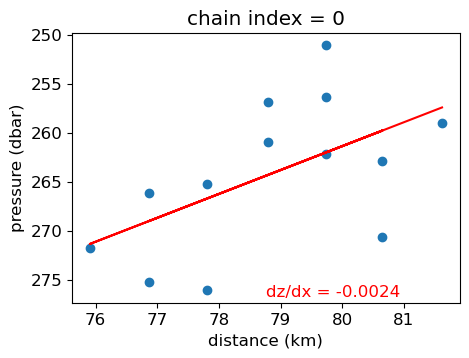

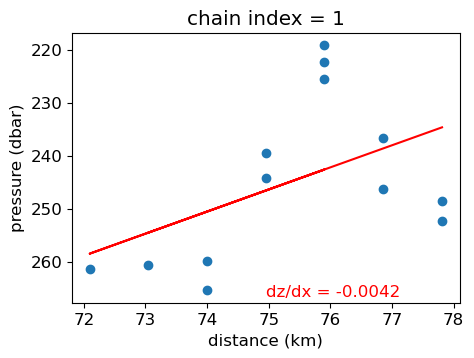

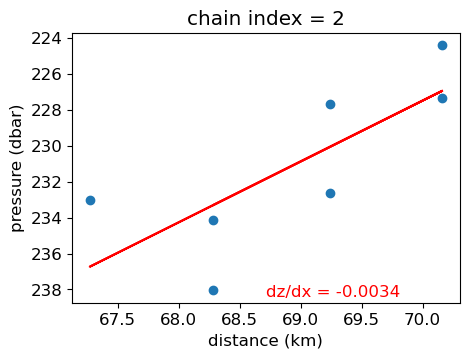

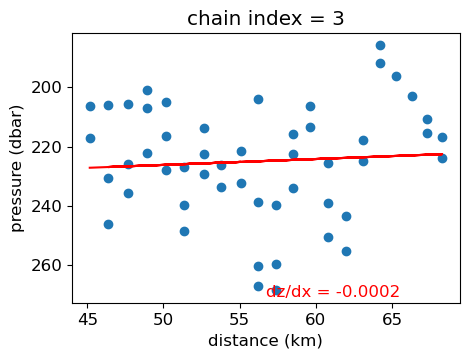

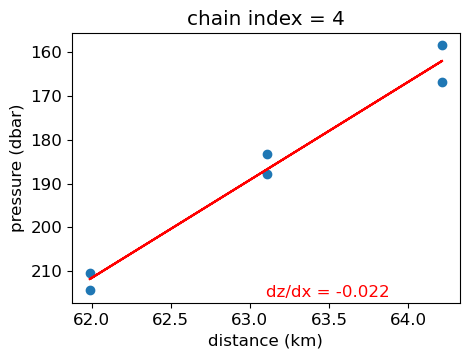

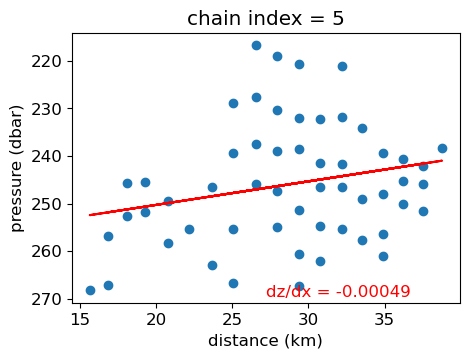

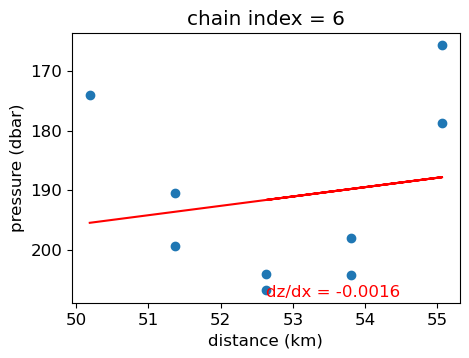

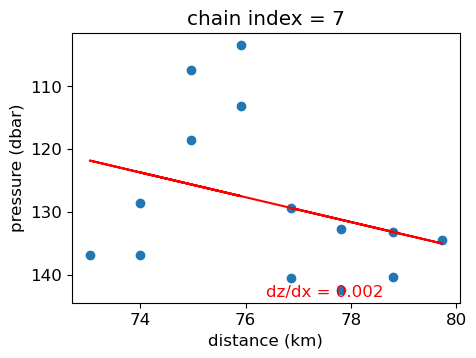

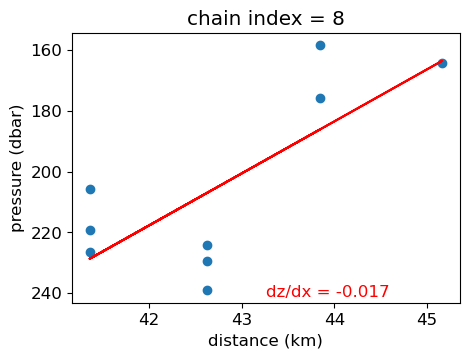

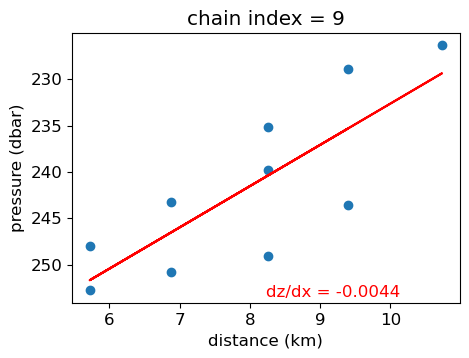

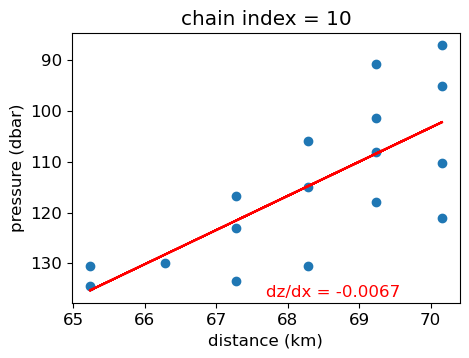

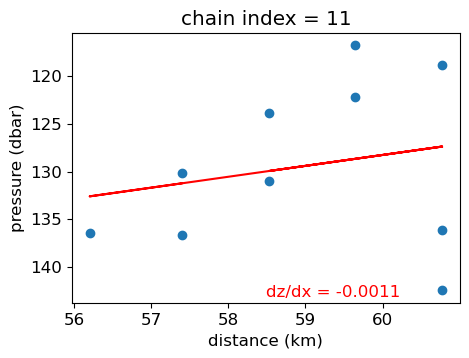

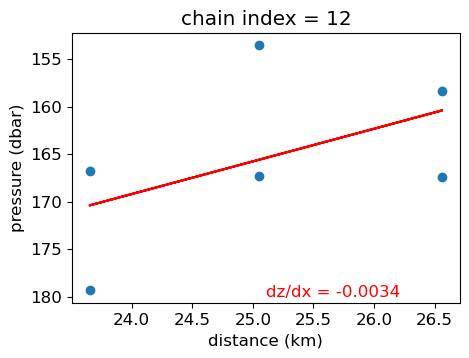

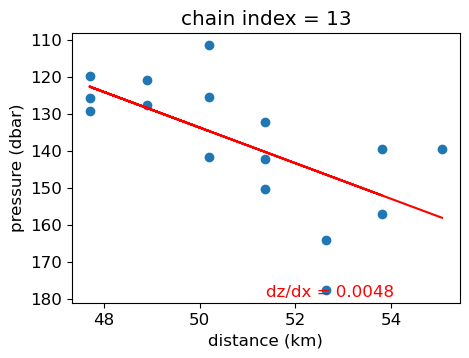

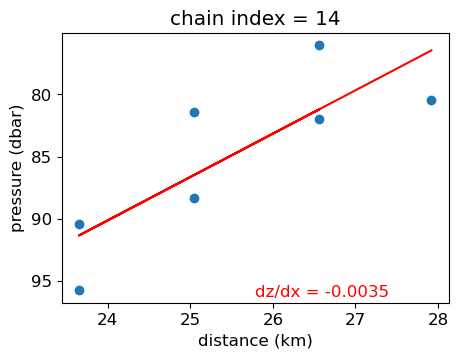

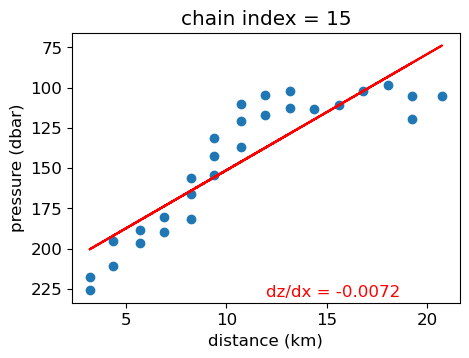

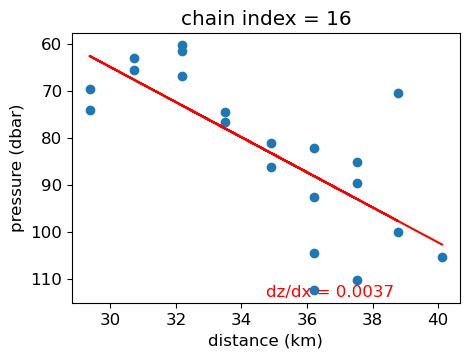

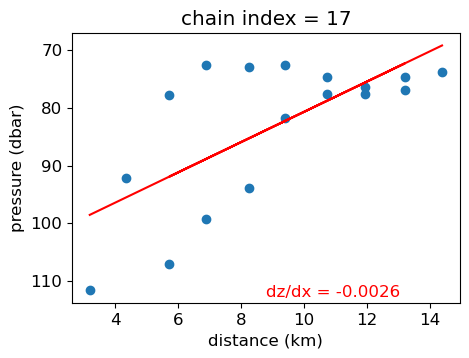

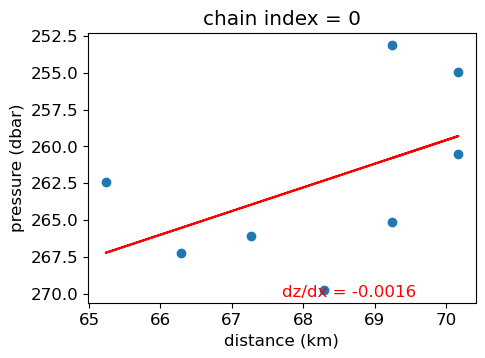

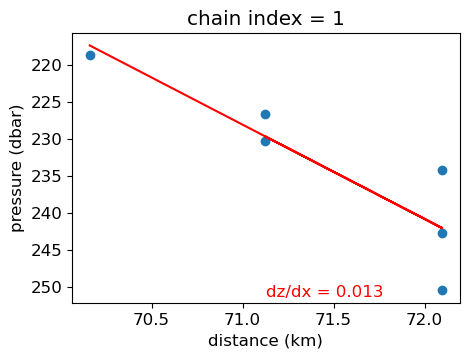

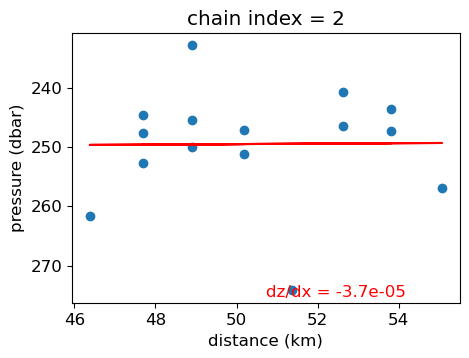

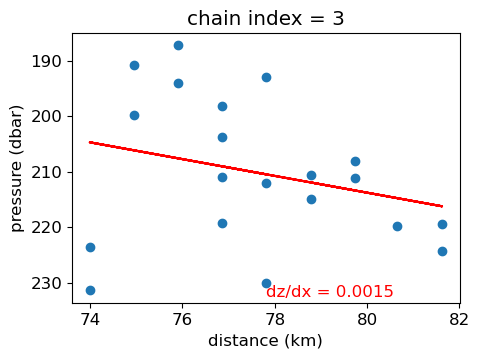

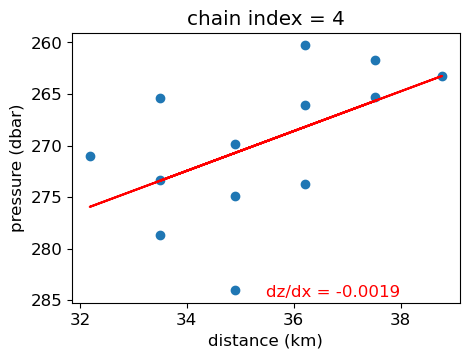

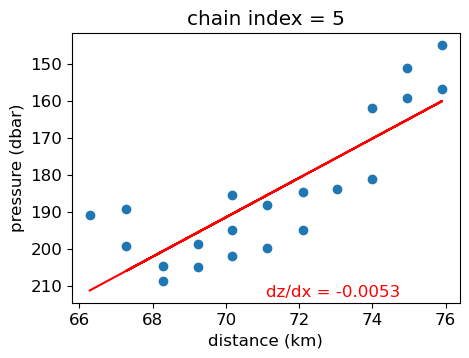

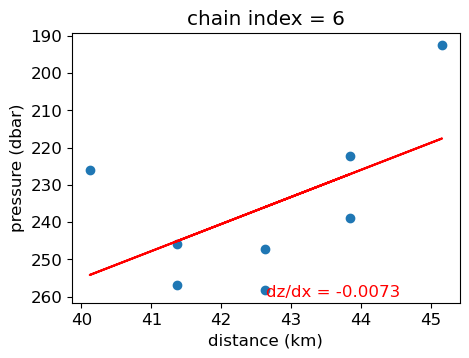

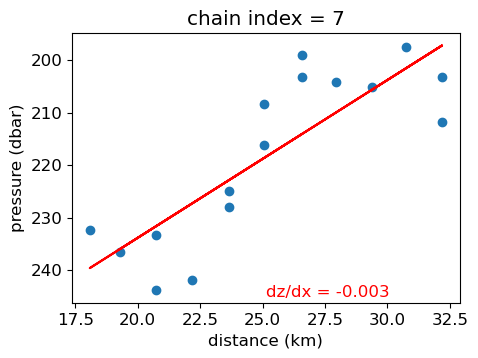

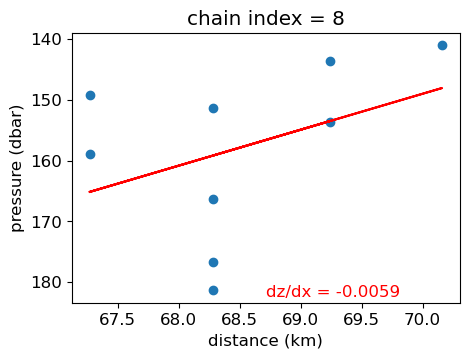

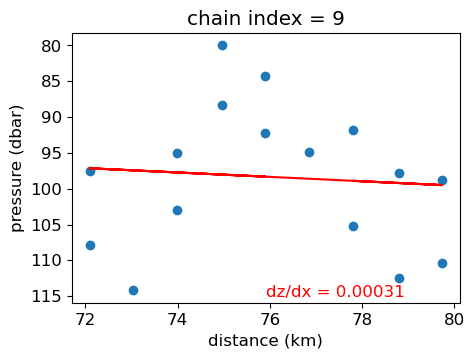

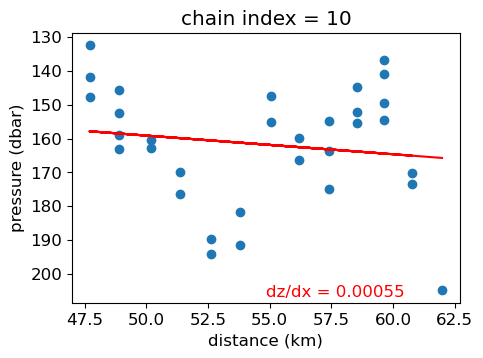

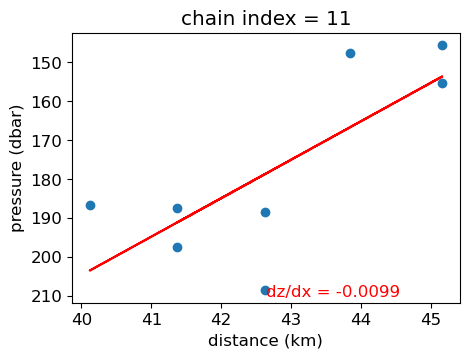

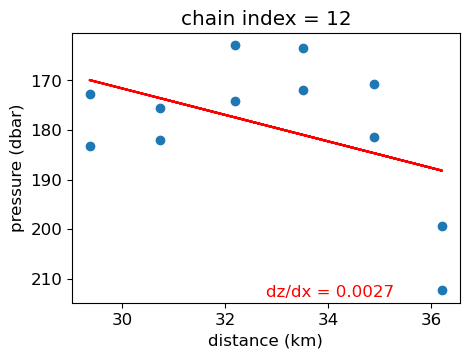

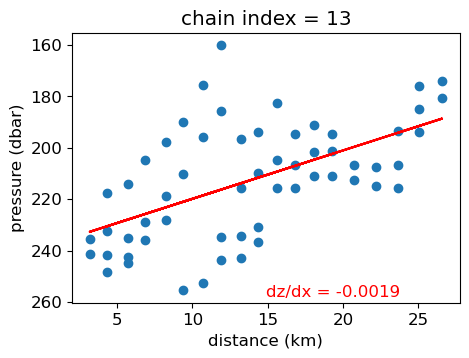

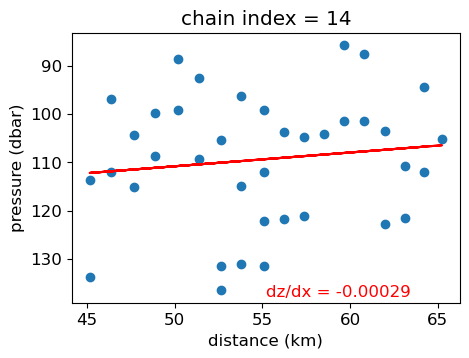

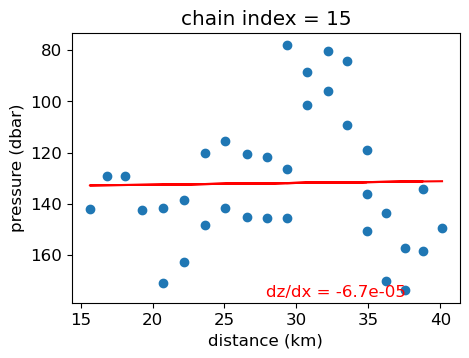

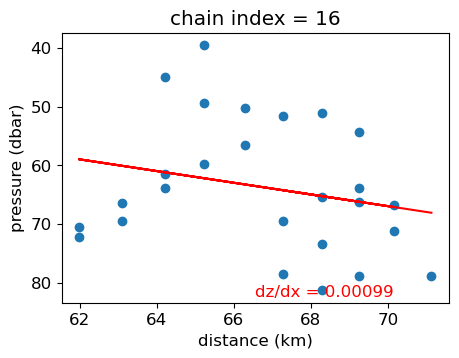

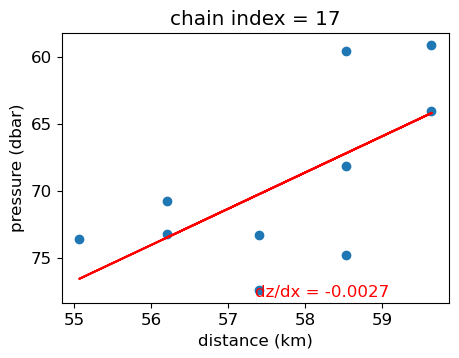

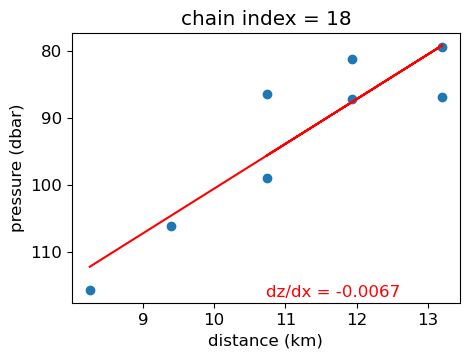

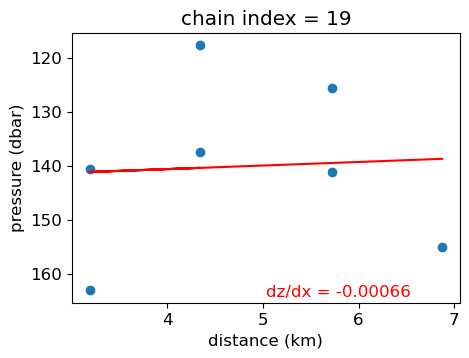

In [66]:
imp.reload(stats)
dzdx_minima = data.get_chain_slope(chain_values_min, P_on_d[tow], dz = 'pressure', plot_slope = True)
dzdx_maxima = data.get_chain_slope(chain_values_max, P_on_d[tow], dz = 'pressure', plot_slope = True)

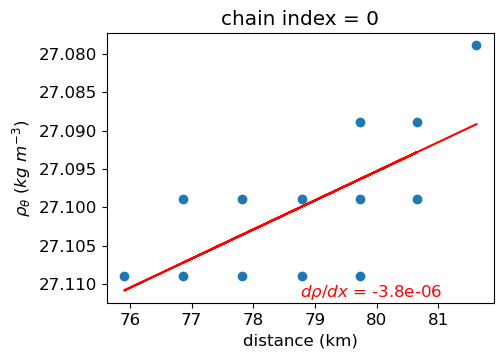

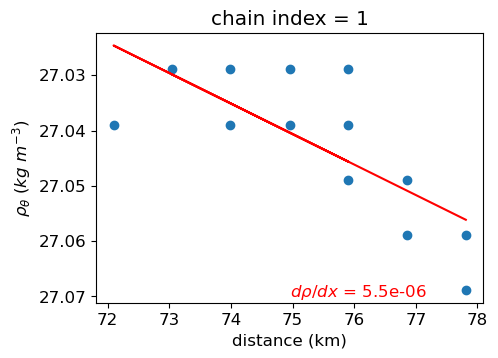

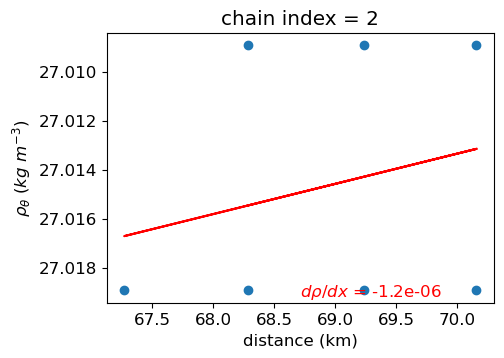

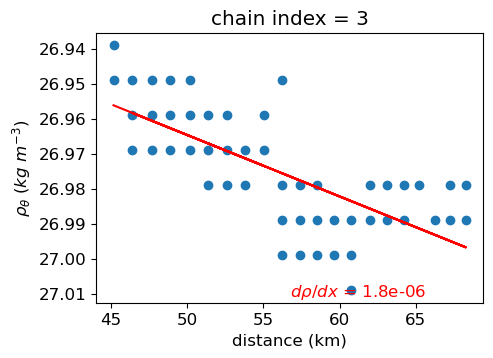

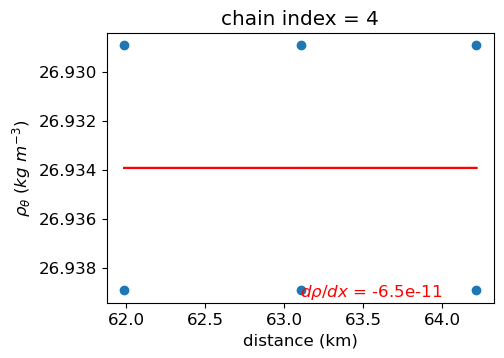

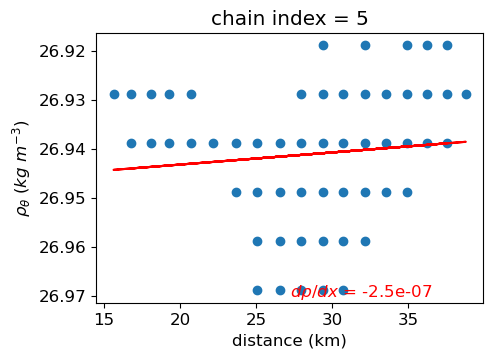

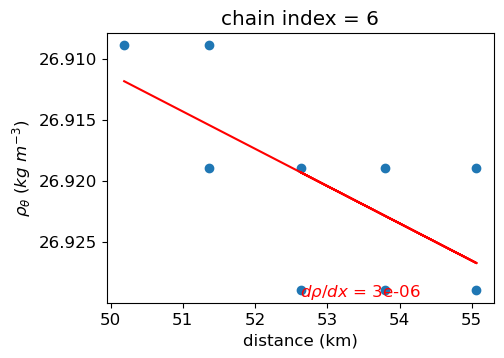

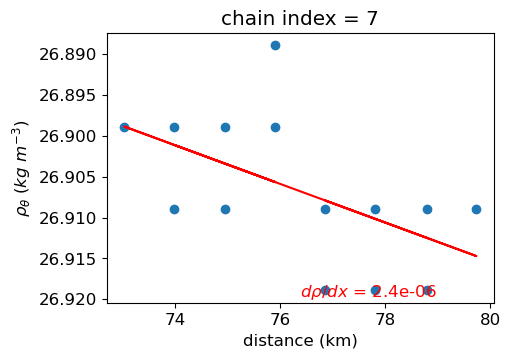

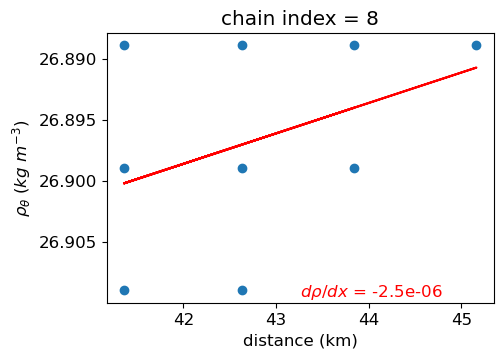

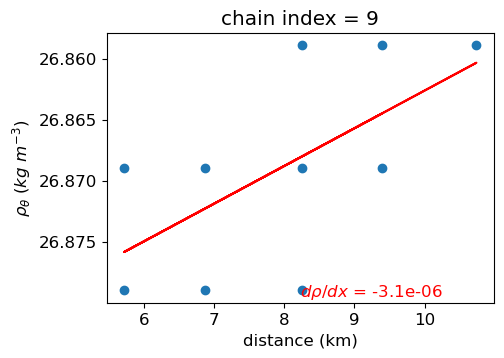

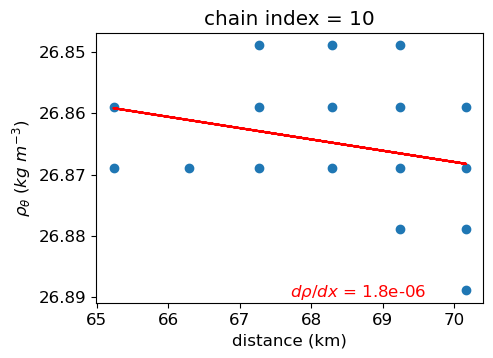

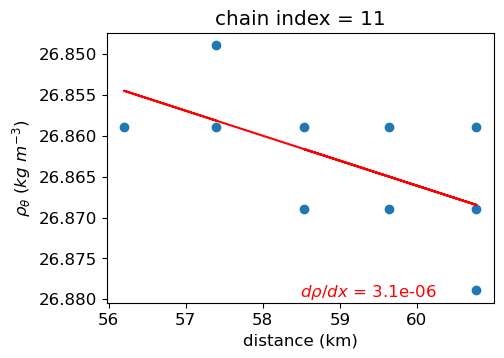

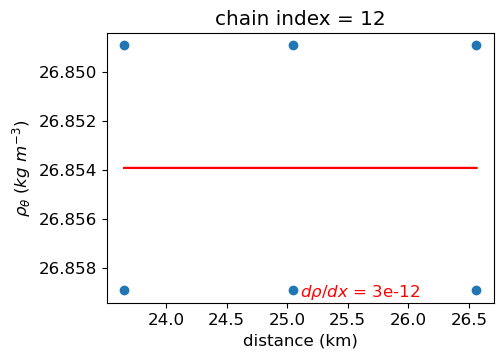

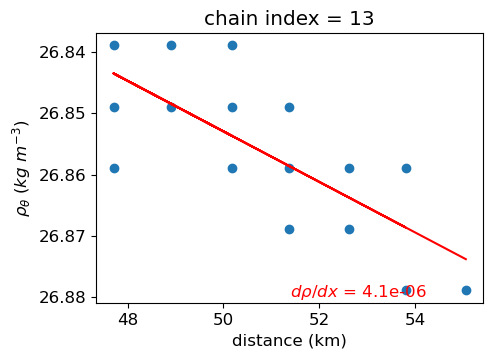

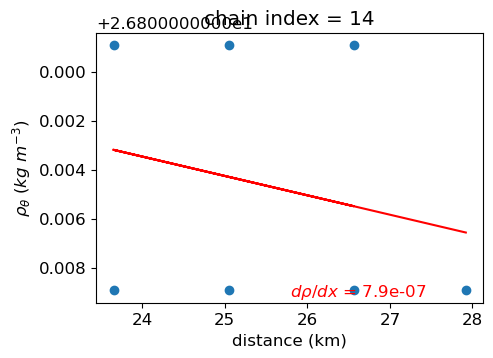

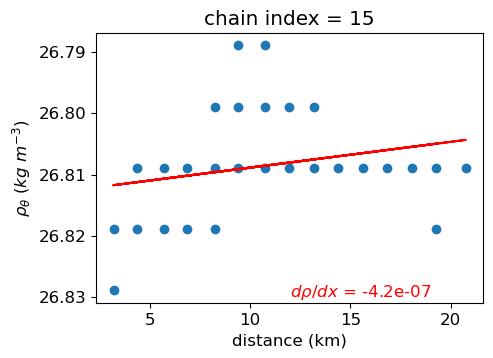

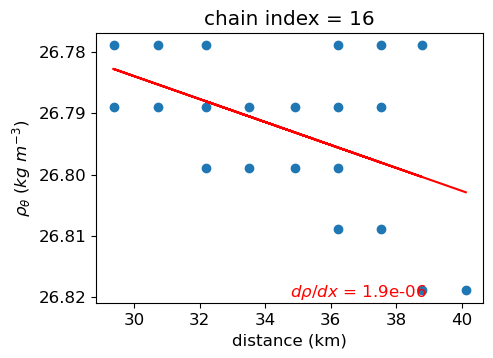

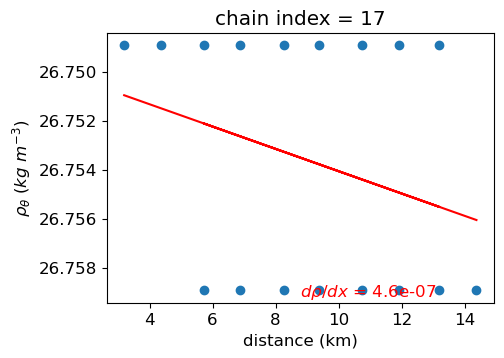

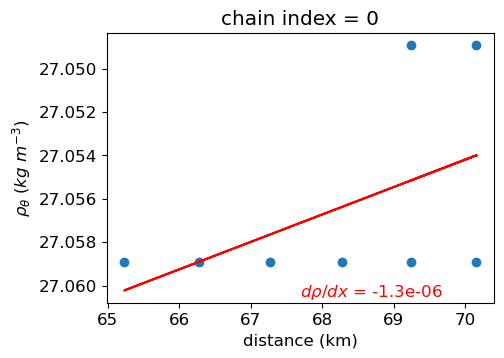

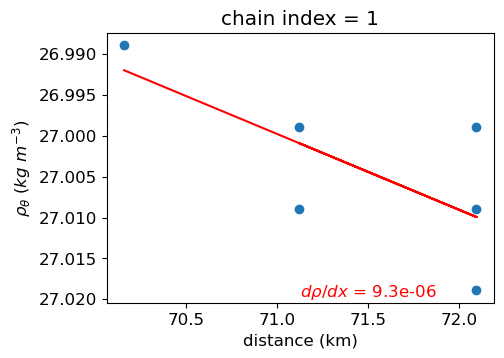

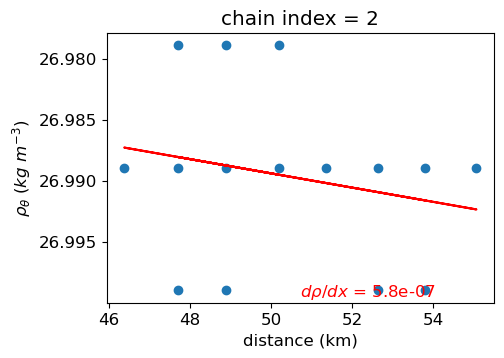

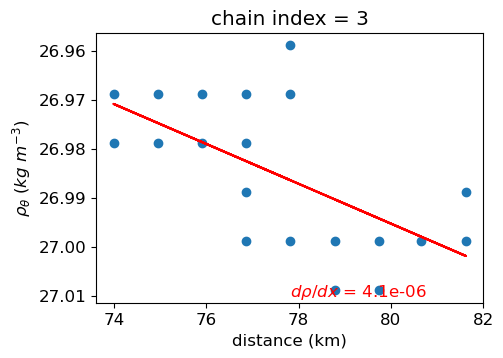

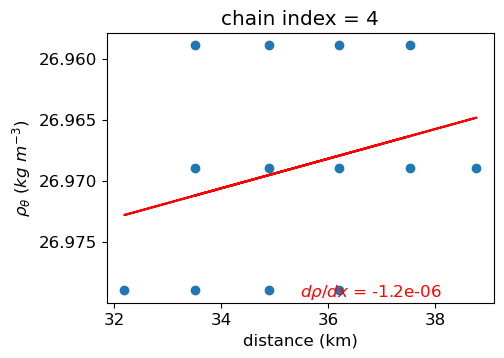

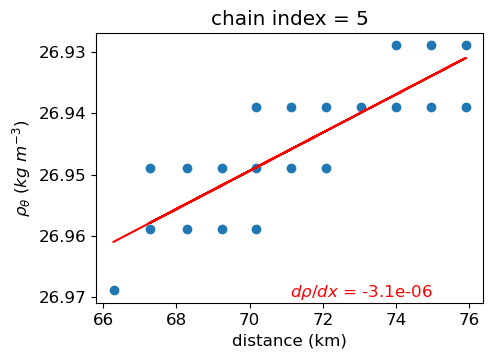

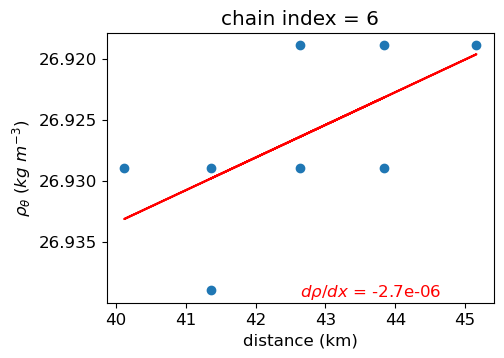

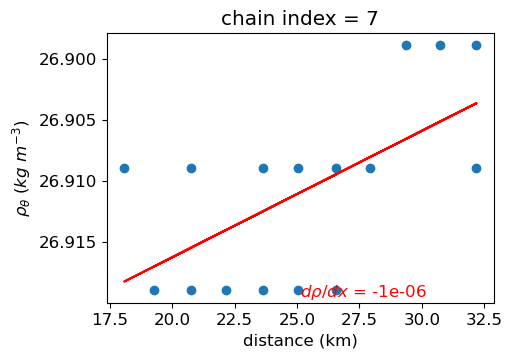

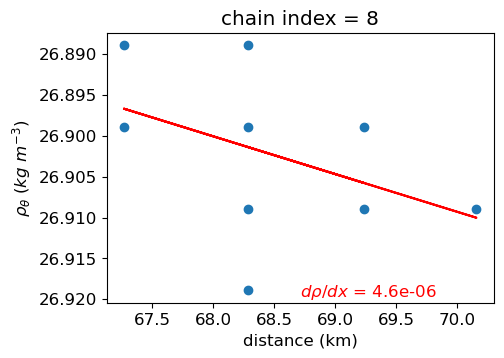

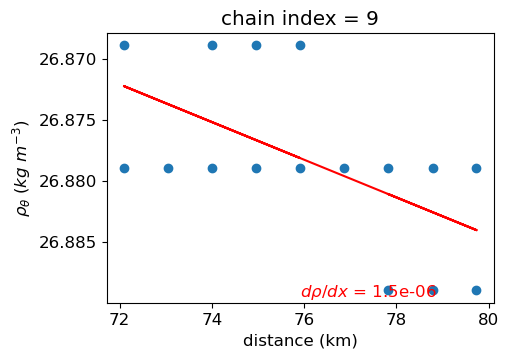

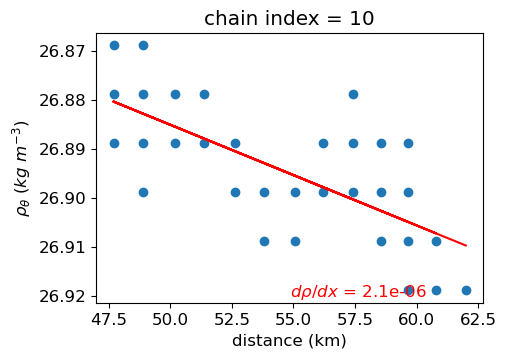

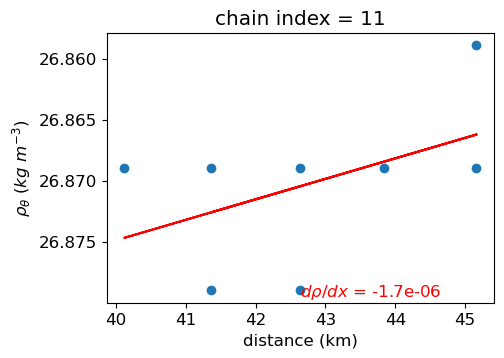

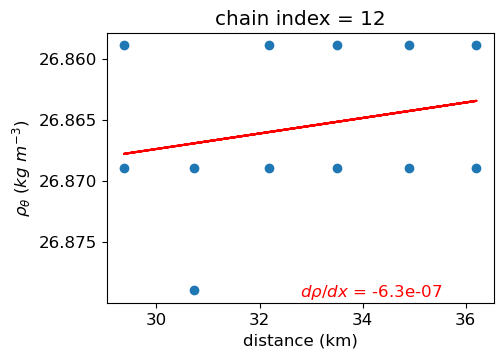

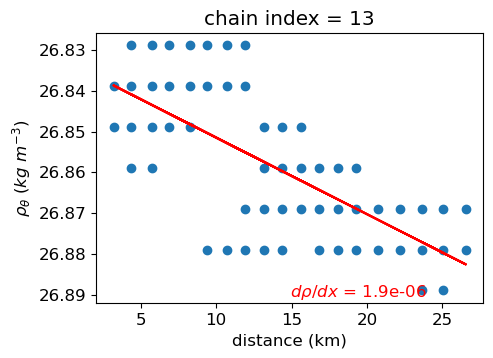

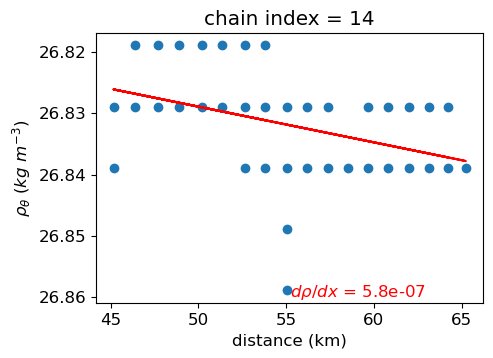

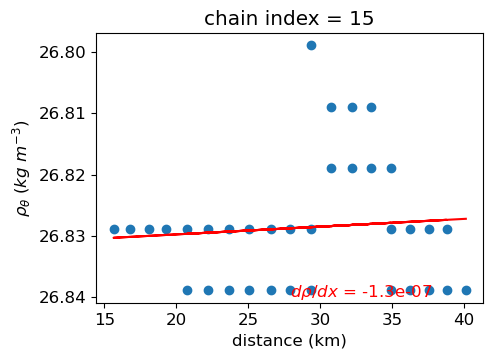

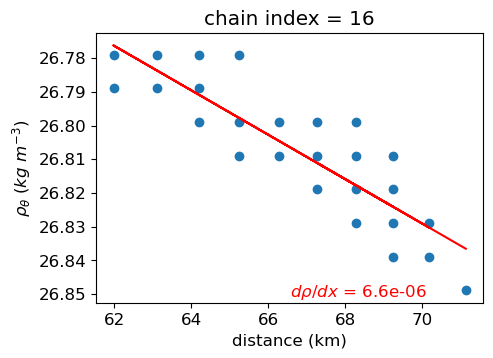

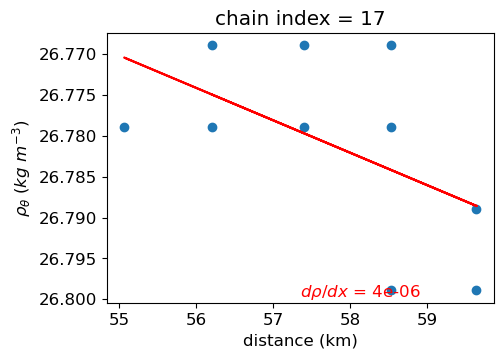

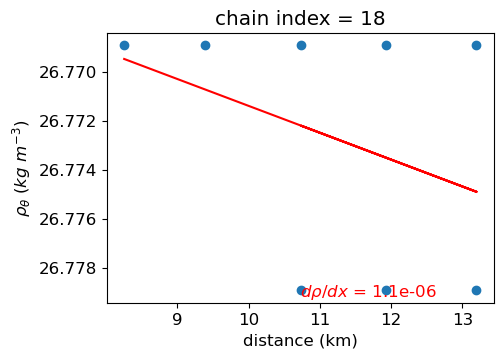

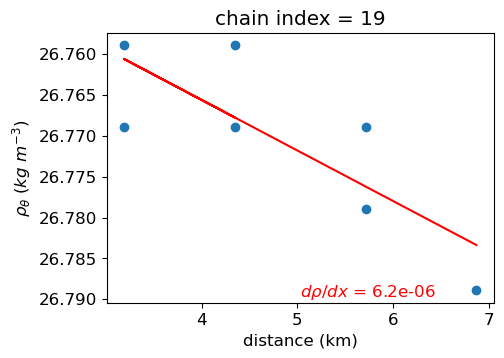

In [67]:
imp.reload(stats)
drhodx_minima = data.get_chain_slope(chain_values_min, P_on_d[tow], dz = 'density', plot_slope = True)
drhodx_maxima = data.get_chain_slope(chain_values_max, P_on_d[tow], dz = 'density', plot_slope = True)

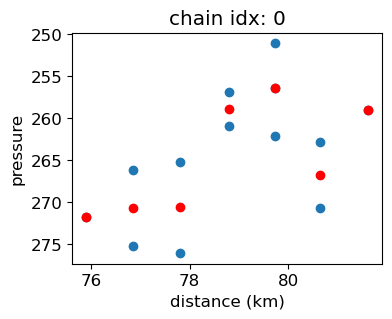

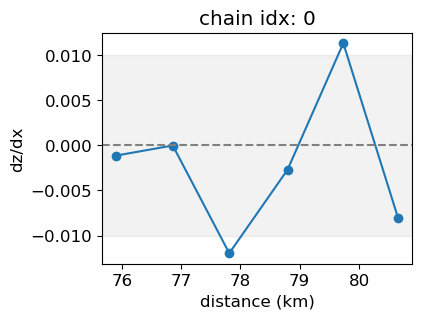

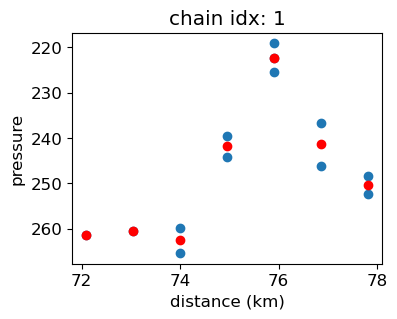

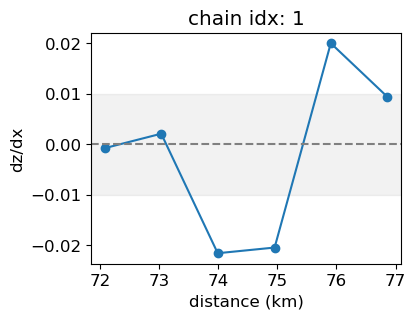

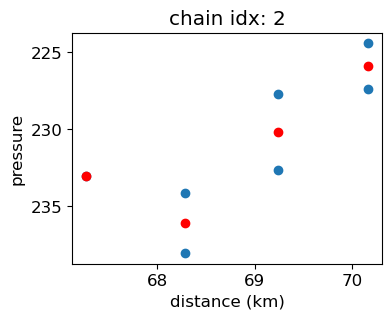

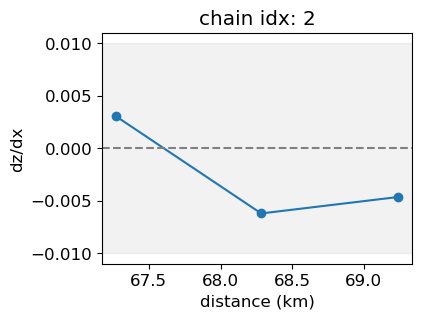

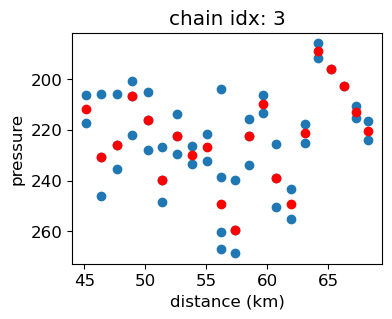

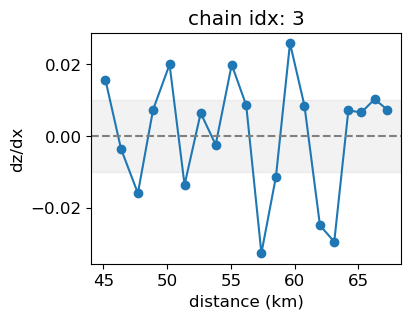

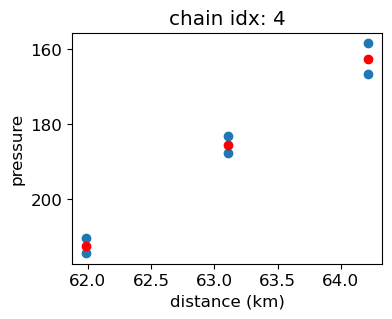

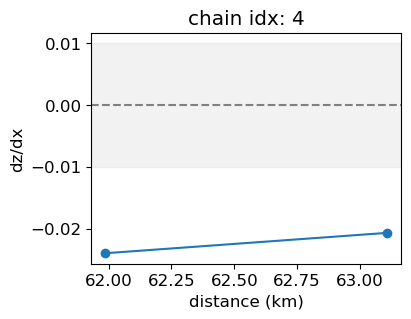

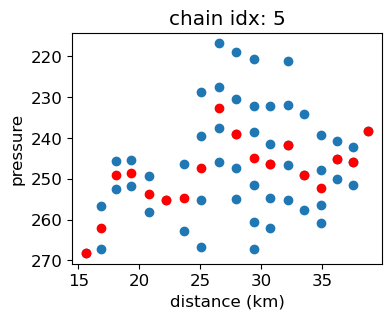

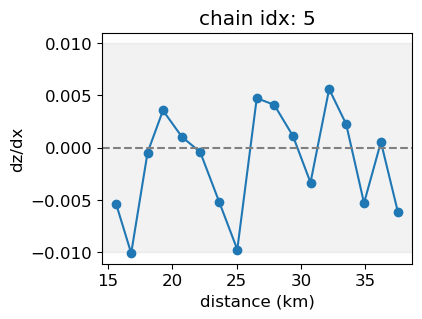

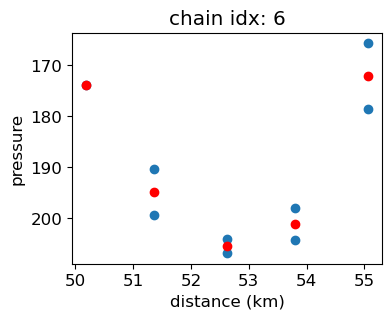

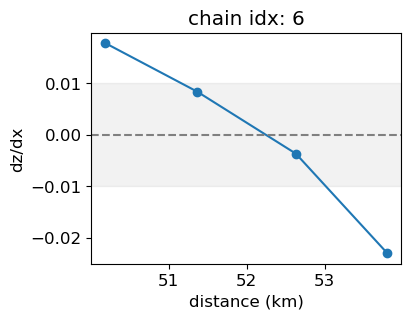

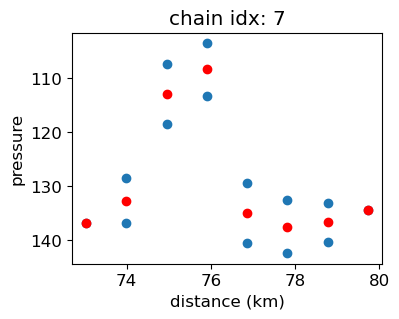

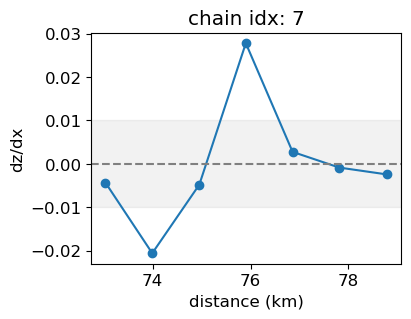

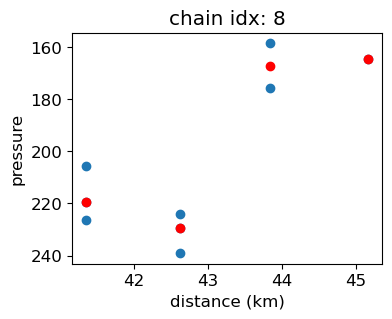

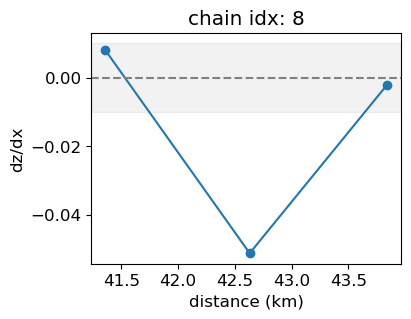

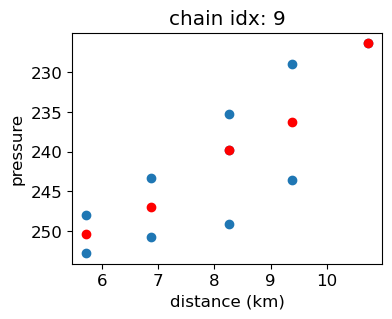

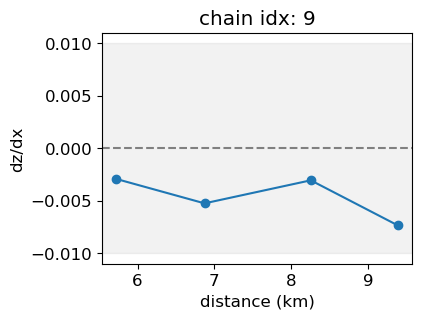

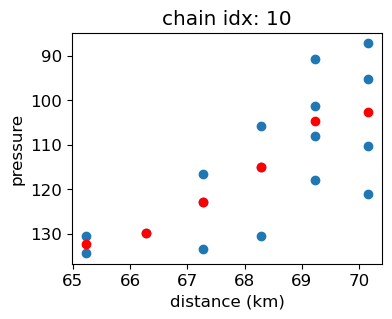

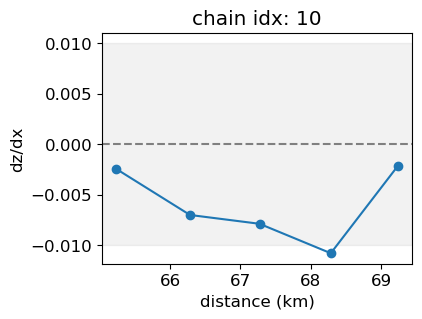

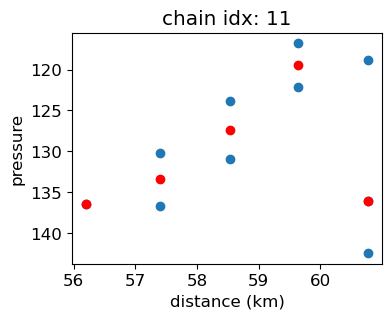

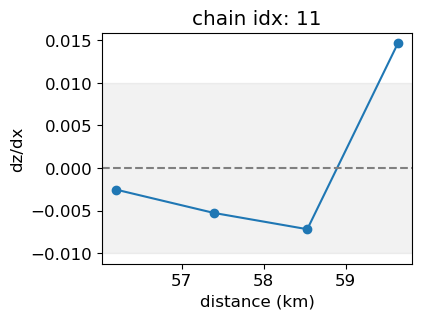

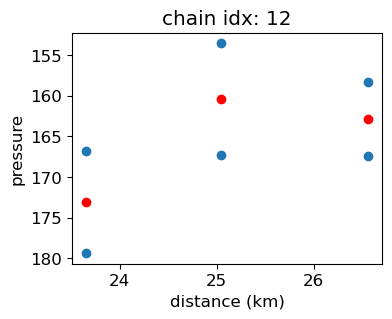

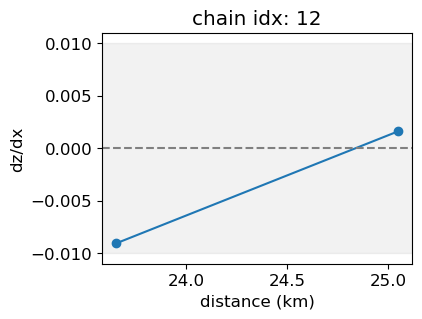

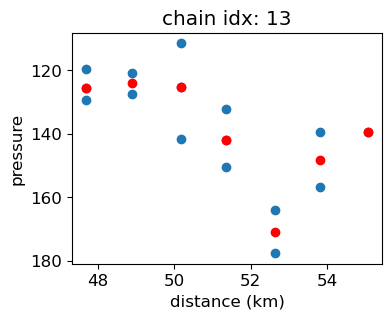

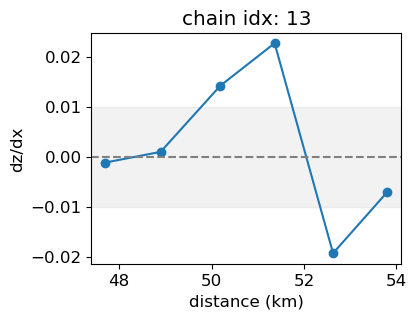

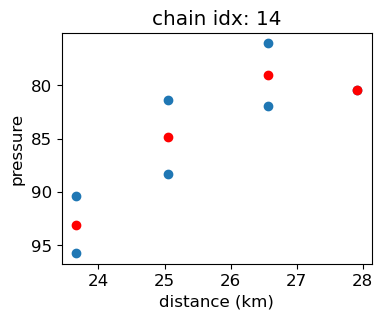

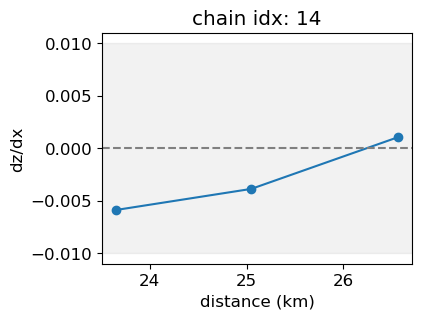

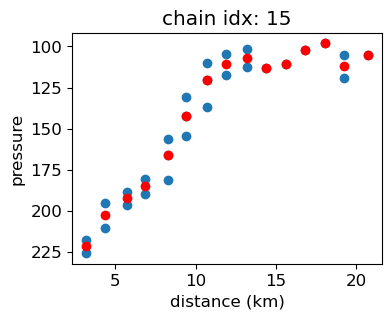

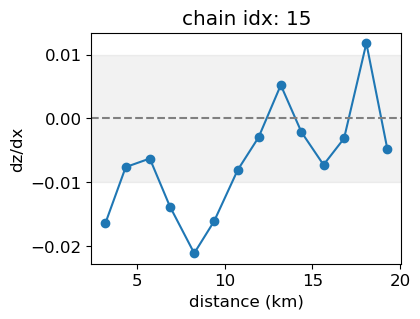

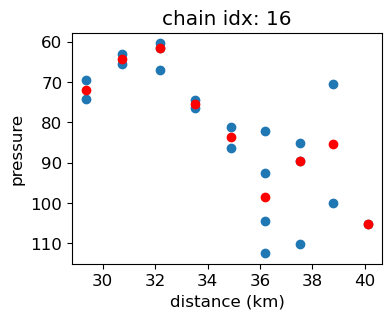

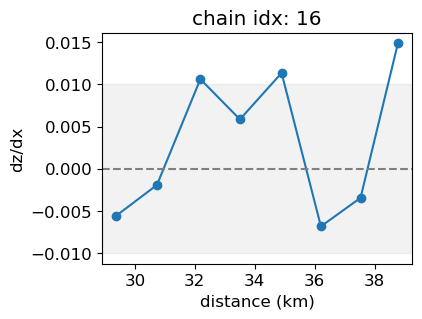

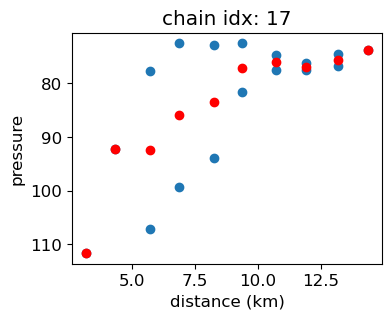

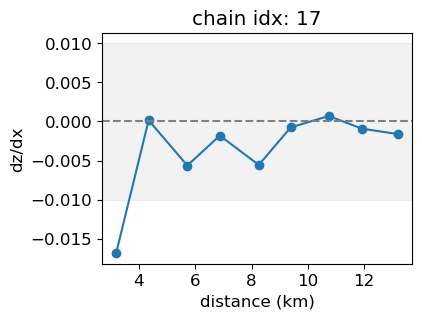

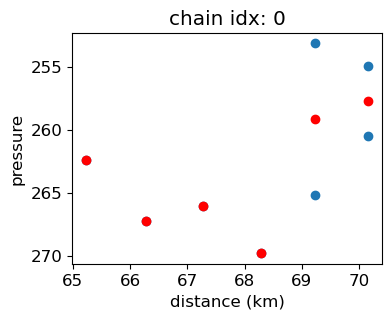

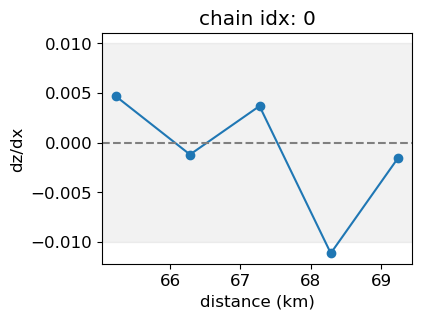

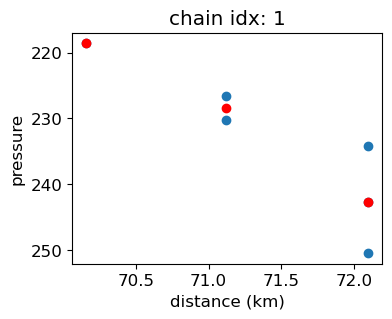

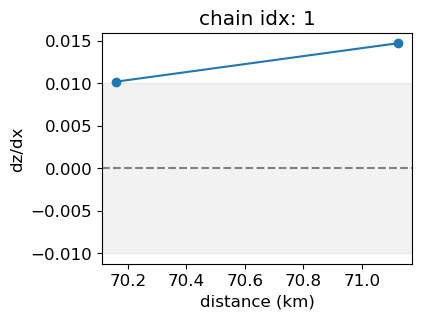

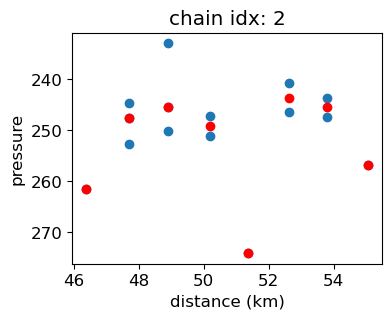

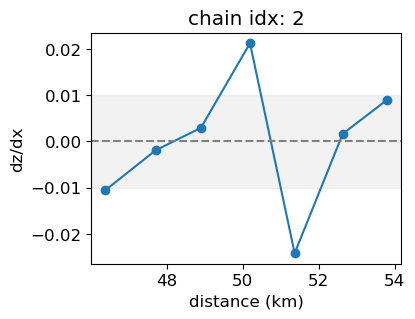

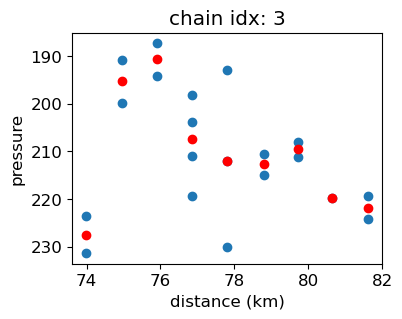

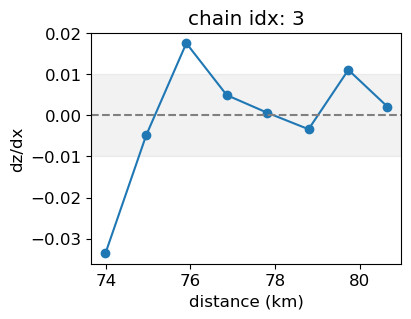

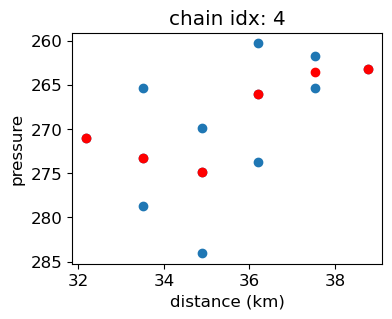

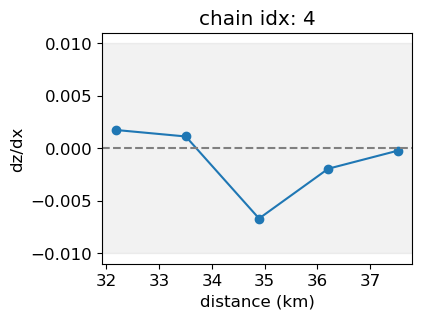

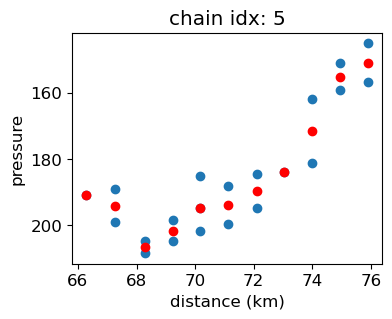

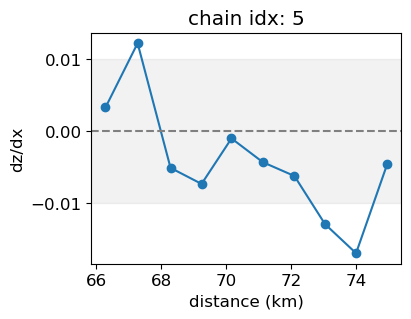

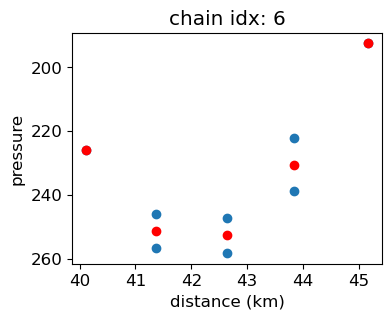

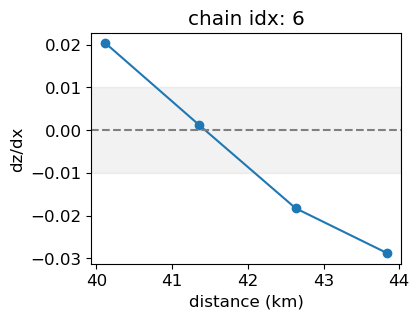

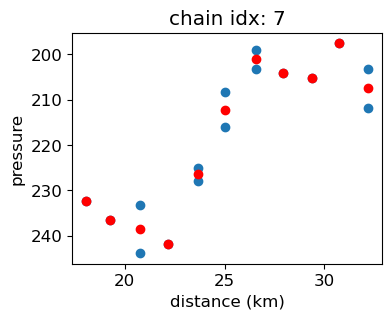

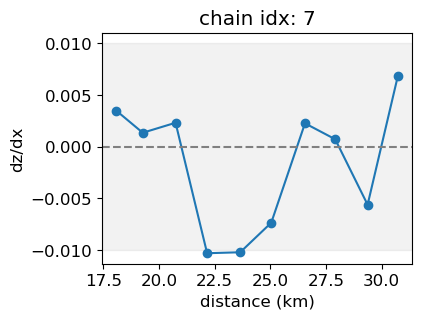

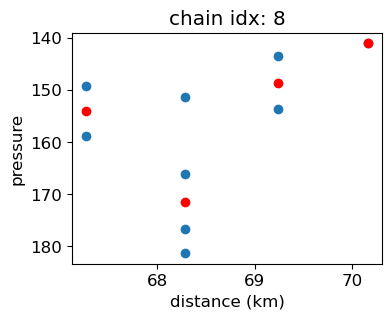

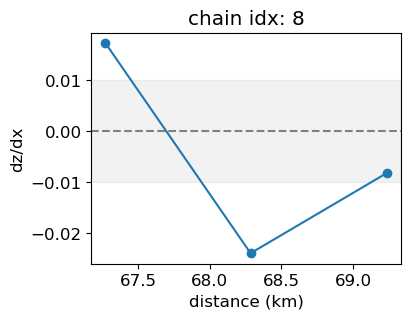

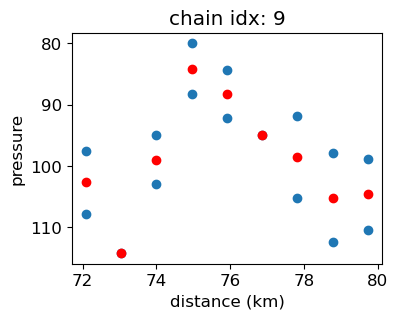

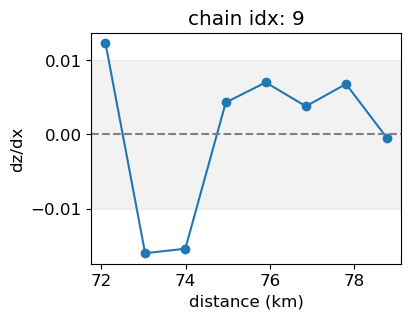

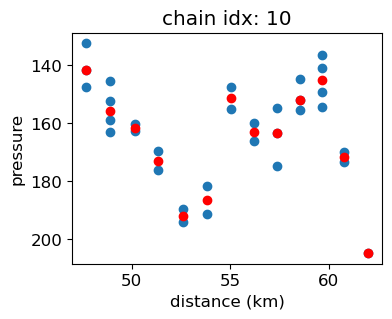

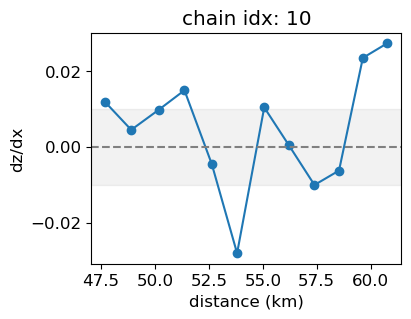

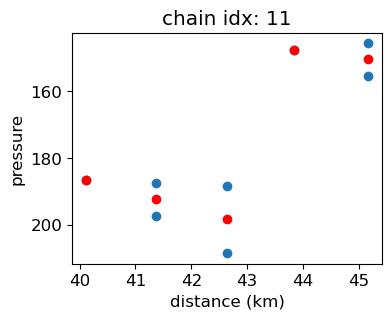

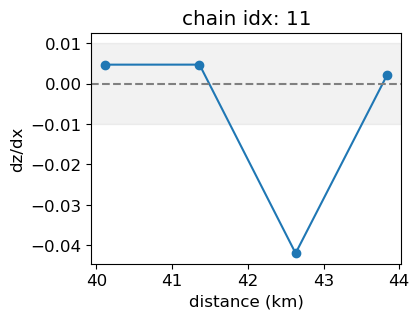

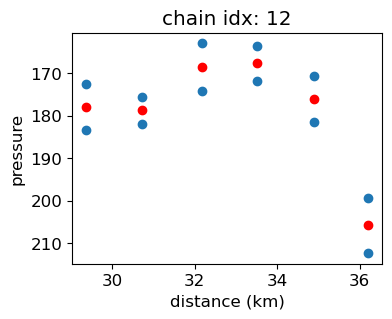

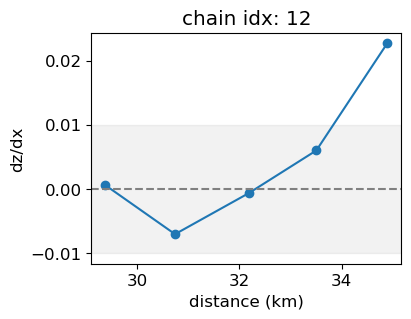

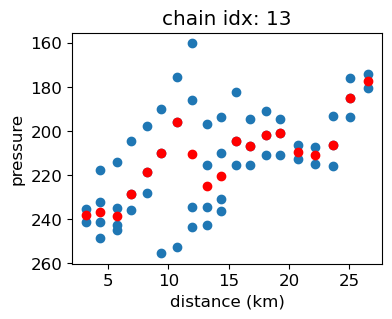

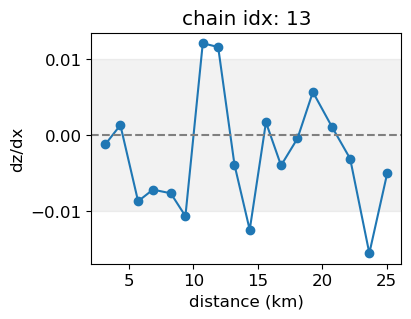

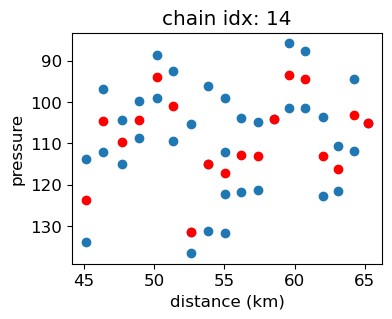

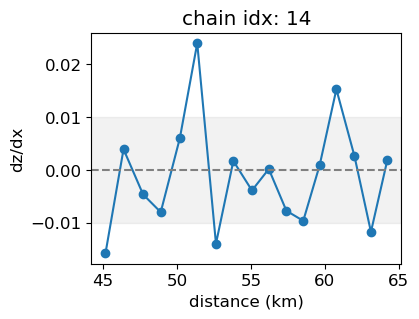

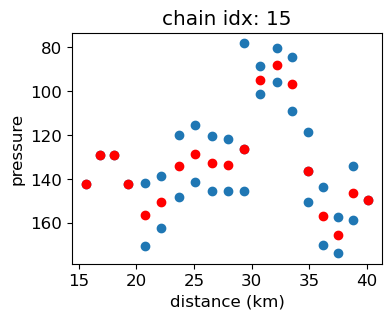

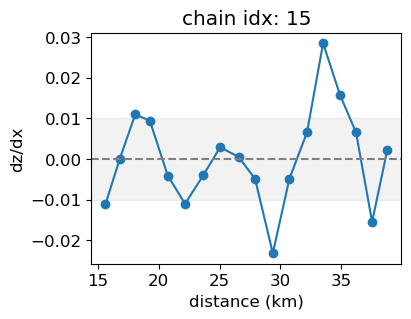

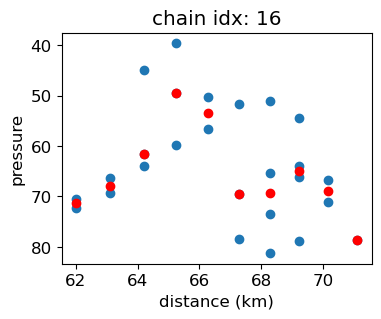

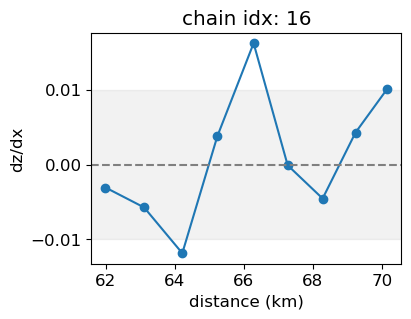

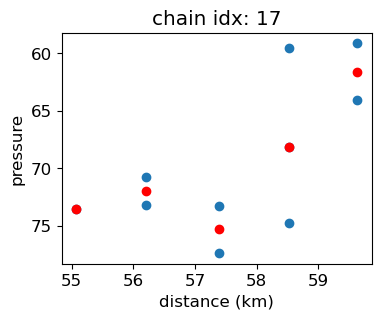

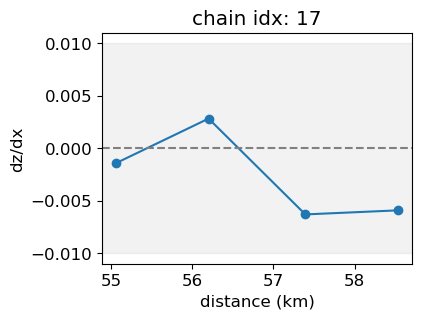

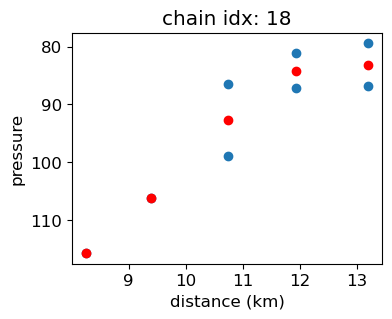

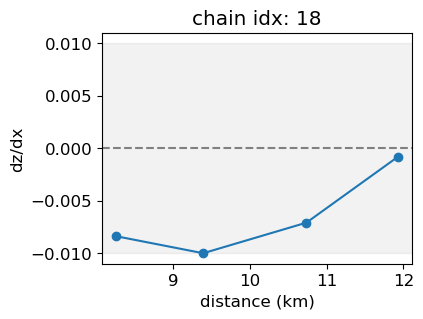

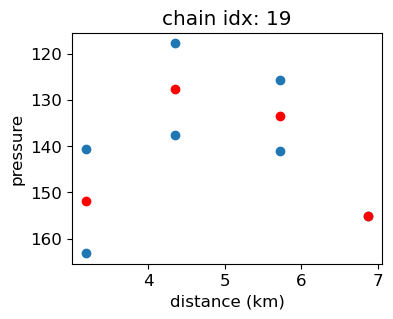

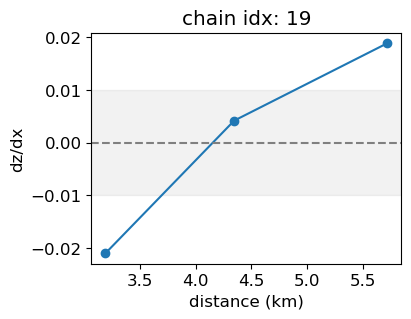

In [68]:
# slope stats
slope_stats_min = data.get_chain_slope_stats(chain_values_min, P_on_d[tow], dz = 'pressure', plot_slope = True)
slope_stats_max = data.get_chain_slope_stats(chain_values_max, P_on_d[tow], dz = 'pressure', plot_slope = True)

In [69]:
latmax = -54.3725 #tow 4
latmin = -56.8656 #tow 7 

f = gsw.f(latmax) #-55.6 #-54.85
N = np.sqrt(8e-5) #1e-5
print(f'Theoretical slope expected from mesoscale stirring: {f/N:.3}')

Theoretical slope expected from mesoscale stirring: -0.0133


In [70]:
### Ekman scale
2*np.pi*(abs(10**-3/10**-4))**(1/2)

19.869176531592203

### Summary statistics

In [71]:
DSC_concat_tri = ct.joinFloats(DSC_smooth, 'distance', new_dim = False)

In [72]:
### Choice of DSC threshold value

nonan = np.where(~np.isnan(DSC_concat_tri.data.flatten()))
da_nonan_tri = DSC_concat_tri.data.flatten()[nonan]

print('90th percentile: ', np.percentile(abs(da_nonan_tri), 90, axis=0))

90th percentile:  2.6276457283387415


In [73]:
dsc_concat_all = np.concatenate([da_nonan_tri, da_nonan_flt])

In [74]:
print('90th percentile: ', np.percentile(abs(dsc_concat_all), 90, axis=0))

90th percentile:  1.8193673681569467


In [75]:
(1.65 + 2.63)/2

2.1399999999999997

In [76]:
print(f'tow index: {i}, tow ID: {tow}')

tow index: 3, tow ID: 04_002


In [77]:
print('Maxima')
imp.reload(stats)
data = stats.FeatureDetection(da)
df_max = data.print_summary_stats(chain_values_max, chain_length_max, H_maxima, chain_slope = drhodx_maxima)
df_max['extrema'] = 'maxima'
df_max['tow'] = i

Maxima
printing overall statistics for features detected
no. features: 20
Feature length
mean L (km): 9.3 +/- 1.5
DSC value
mean value: 2.49 +/- 0.17
Height of features
mean H maxima: 11.61 +/- 1.40
slope (drho/dx)
mean avg slope: 1.5e-06 +/- 7.4e-07
max avg slope = 9.280574468441591e-06
min avg slope = -3.1212115095670708e-06


In [78]:
print('Minima')
df_min = data.print_summary_stats(chain_values_min, chain_length_min, H_minima, chain_slope = drhodx_minima)
df_min['extrema'] = 'minima'
df_min['tow'] = i

Minima
printing overall statistics for features detected
no. features: 18
Feature length
mean L (km): 8.2 +/- 1.6
DSC value
mean value: -3.05 +/- 0.42
Height of features
mean H maxima: 10.57 +/- 1.11
slope (drho/dx)
mean avg slope: 7.5e-07 +/- 5.8e-07
max avg slope = 5.518253260405892e-06
min avg slope = -3.7869293429567873e-06


In [79]:
df = df_min.append(df_max)

In [256]:
# my_pal = {"maxima": "tab:green", "minima": "tab:pink"}

# fig, ax = plt.subplots(figsize = (5,5))
# sns.boxplot(data=df, x= 'extrema', y="mean_height", palette=my_pal, width = .5,
#            linewidth = 1.2, fliersize = 2.5, boxprops=dict(alpha=.8))
# plt.xlabel('')
# plt.ylabel('length (km)')

In [80]:
import pandas as pd

imp.reload(stats)

chain_d_slopes = pd.DataFrame(columns = drhodx_maxima.columns)
chain_p_slopes = pd.DataFrame(columns = dzdx_maxima.columns)
slope_stats = pd.DataFrame(columns = slope_stats_min.columns)
all_data = pd.DataFrame(columns = df_max.columns)

i = 1
for tow in lst:
    dataArray = DSC_smooth[tow]

    da_prof = xr.DataArray(dataArray.data, dims = ['profile', 'potential_density'], 
                           coords = dict(potential_density = ('potential_density', dataArray.potential_density.data), 
                                        profile = ('profile', np.arange(0, len(dataArray)))))
    
    data = stats.FeatureDetection(da_prof.transpose())
    threshold_value = 2
    
    # MAXIMA
    lower_val = threshold_value
    upper_val = np.inf
    fill_val = 999

    contours_max = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)
    filtered = data.filter_chains(contours_max, min_len = 6)
    filtered_chains_max = list(np.asarray(contours_max)[filtered])
    
    chain_values_max = data.get_chain_values(filtered_chains_max, fillvalue = fill_val)
    chain_length_max = data.get_chain_lengths(chain_values_max, dataArray.distance)
    H_max = data.get_chain_heights(chain_values_max, P_on_d[tow])
    
    # dataframe with lengths, mean DSC, and mean H for each feature in all triaxus tows
    df_max = data.print_summary_stats(chain_values_max, chain_length_max, H_max)
    df_max['extrema'] = 'maxima'
    df_max['tow'] = i
    
    # slopes relative to density
    drhodx_maxima = data.get_chain_slope(chain_values_max, P_on_d[tow], dz = 'density', plot_slope = False)
    drhodx_maxima['tow'] = i
    drhodx_maxima['extrema'] = 'maxima'
    chain_d_slopes = chain_d_slopes.append(drhodx_maxima)
    
    # slopes relative to pressure 
    dzdx_maxima = data.get_chain_slope(chain_values_max, P_on_d[tow], dz = 'pressure', plot_slope = False)
    dzdx_maxima['tow'] = i
    dzdx_maxima['extrema'] = 'maxima'
    chain_p_slopes = chain_p_slopes.append(dzdx_maxima)
        
    # slope stats
    slope_stats_max = data.get_chain_slope_stats(chain_values_max, P_on_d[tow], dz = 'pressure', plot_slope = False)
    slope_stats_max['tow'] = i
    slope_stats_max['extrema'] = 'maxima'
    slope_stats = slope_stats.append(slope_stats_max)

    #-------------------------------------------------------------------------------------------------------------------
    # MINIMA
    lower_val = -np.inf
    upper_val = -threshold_value
    
    contours_min = data.find_contours(lower_threshold = lower_val, upper_threshold = upper_val)
    filtered = data.filter_chains(contours_min, min_len = 6)
    filtered_chains_min = list(np.asarray(contours_min)[filtered])
    
    chain_values_min = data.get_chain_values(filtered_chains_min, fillvalue = -fill_val)
    chain_length_min = data.get_chain_lengths(chain_values_min, dataArray.distance)
    H_min = data.get_chain_heights(chain_values_min, P_on_d[tow])
    
    # dataframe with lengths, mean DSC, and mean H for each feature in all triaxus tows
    df_min = data.print_summary_stats(chain_values_min, chain_length_min, H_min)
    df_min['extrema'] = 'minima'
    df_min['tow'] = i
    
    df = df_min.append(df_max)
    all_data = all_data.append(df)
    
    # slopes relative to density
    drhodx_minima = data.get_chain_slope(chain_values_min, P_on_d[tow], dz = 'density', plot_slope = False)
    drhodx_minima['tow'] = i
    drhodx_minima['extrema'] = 'minima'
    chain_d_slopes = chain_d_slopes.append(drhodx_minima)
    
    # slopes relative to pressure 
    dzdx_minima = data.get_chain_slope(chain_values_min, P_on_d[tow], dz = 'pressure', plot_slope = False)
    dzdx_minima['tow'] = i
    dzdx_minima['extrema'] = 'minima'
    chain_p_slopes = chain_p_slopes.append(dzdx_minima)
    
    # slope stats
    slope_stats_min = data.get_chain_slope_stats(chain_values_min, P_on_d[tow], dz = 'pressure', plot_slope = False)
    slope_stats_min['tow'] = i
    slope_stats_min['extrema'] = 'minima'
    slope_stats = slope_stats.append(slope_stats_min)
    

    i+=1


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 8
Feature length
mean L (km): 8.2 +/- 1.9
DSC value
mean value: 3.14 +/- 0.25
Height of features
mean H maxima: 7.97 +/- 1.15


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 6
Feature length
mean L (km): 7.1 +/- 1.2
DSC value
mean value: -3.07 +/- 0.31
Height of features
mean H maxima: 7.98 +/- 0.81


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 10
Feature length
mean L (km): 6.4 +/- 1.0
DSC value
mean value: 3.69 +/- 0.23
Height of features
mean H maxima: 10.96 +/- 2.07


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 5
Feature length
mean L (km): 9.1 +/- 2.6
DSC value
mean value: -4.37 +/- 0.28
Height of features
mean H maxima: 14.14 +/- 3.37


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 13
Feature length
mean L (km): 6.3 +/- 0.9
DSC value
mean value: 3.18 +/- 0.17
Height of features
mean H maxima: 10.19 +/- 2.09


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 12
Feature length
mean L (km): 5.7 +/- 1.0
DSC value
mean value: -3.34 +/- 0.27
Height of features
mean H maxima: 8.15 +/- 1.36


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 13
Feature length
mean L (km): 7.4 +/- 0.9
DSC value
mean value: 3.73 +/- 0.50
Height of features
mean H maxima: 11.52 +/- 1.81


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 12
Feature length
mean L (km): 8.0 +/- 1.5
DSC value
mean value: -4.12 +/- 0.54
Height of features
mean H maxima: 10.71 +/- 1.50


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 13
Feature length
mean L (km): 11.7 +/- 2.4
DSC value
mean value: 4.44 +/- 0.24
Height of features
mean H maxima: 17.90 +/- 2.93


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 18
Feature length
mean L (km): 8.1 +/- 1.5
DSC value
mean value: -4.22 +/- 0.23
Height of features
mean H maxima: 10.88 +/- 0.87


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 4
Feature length
mean L (km): 7.6 +/- 1.9
DSC value
mean value: 3.35 +/- 0.13
Height of features
mean H maxima: 13.06 +/- 3.35


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 3
Feature length
mean L (km): 7.6 +/- 2.2
DSC value
mean value: -3.74 +/- 0.40
Height of features
mean H maxima: 14.87 +/- 5.97


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 10
Feature length
mean L (km): 9.0 +/- 2.2
DSC value
mean value: 3.89 +/- 0.22
Height of features
mean H maxima: 13.43 +/- 1.98


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 8
Feature length
mean L (km): 8.4 +/- 2.3
DSC value
mean value: -3.54 +/- 0.29
Height of features
mean H maxima: 9.07 +/- 1.24


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 4
Feature length
mean L (km): 8.0 +/- 3.2
DSC value
mean value: 2.91 +/- 0.13
Height of features
mean H maxima: 12.53 +/- 4.10


C:\Users\mijakes\Anaconda3\envs\analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


printing overall statistics for features detected
no. features: 8
Feature length
mean L (km): 5.6 +/- 1.1
DSC value
mean value: -4.06 +/- 0.41
Height of features
mean H maxima: 9.74 +/- 0.92


## Histograms

In [81]:
all_data

chain_idx     length  mean_height  mean_value extrema tow
0          0   4.070506    10.522120   -2.873932  minima   1
1          1   5.676138     6.861452   -2.175163  minima   1
2          2  10.334259     4.960760   -2.424184  minima   1
3          3  10.549876     9.453299   -3.077114  minima   1
4          4   4.582238     8.571921   -3.726115  minima   1
..       ...        ...          ...         ...     ...  ..
7          7   7.979852     6.827565   -5.098158  minima   8
0          0   2.781255    13.387602    2.914746  maxima   8
1          1   8.363862     6.731210    2.534403  maxima   8
2          2   3.925921     6.211830    3.064262  maxima   8
3          3  16.758185    23.803387    3.130333  maxima   8

[147 rows x 6 columns]

In [90]:
all_data[all_data['extrema'] == 'maxima']

chain_idx     length  mean_height  mean_value extrema tow
0          0   3.999541     6.508628    2.726691  maxima   1
1          1   7.620565     5.583029    4.008887  maxima   1
2          2   4.492195     5.152951    4.356127  maxima   1
3          3   3.999541    10.186526    2.677369  maxima   1
4          4  15.885431    10.277687    3.149539  maxima   1
..       ...        ...          ...         ...     ...  ..
9          9  20.972279    22.463530    3.862721  maxima   7
0          0   2.781255    13.387602    2.914746  maxima   8
1          1   8.363862     6.731210    2.534403  maxima   8
2          2   3.925921     6.211830    3.064262  maxima   8
3          3  16.758185    23.803387    3.130333  maxima   8

[75 rows x 6 columns]

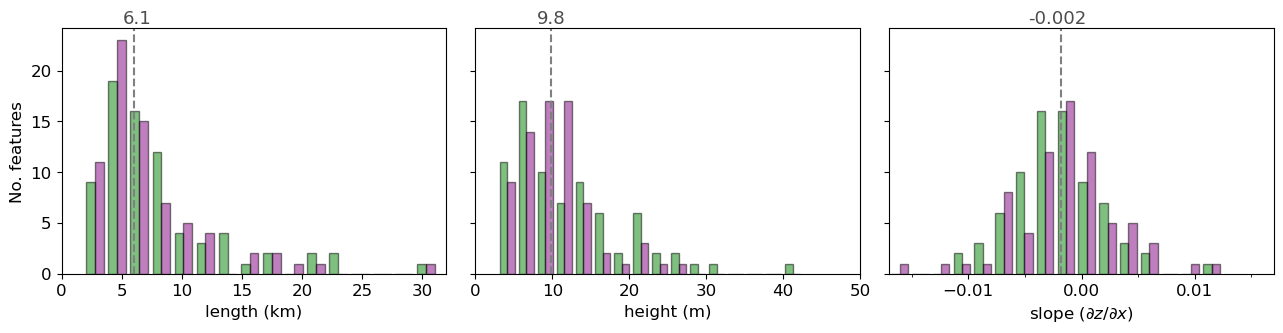

In [82]:
minima = all_data['extrema'] == 'minima'
maxima = all_data['extrema'] == 'maxima'
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (13,3.5))

# Length
n, bins, patches = ax1.hist(x=[all_data['length'][maxima], all_data['length'][minima]], 
                            bins = 16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)


median = all_data['length'].median()
ax1.axvline(x = median, linestyle = '--', c = 'grey')
ax1.text(0.16, 1.02, f'{median:.1f}', transform = ax1.transAxes, c = 'k', alpha = 0.7, fontsize = 13)
ax1.set_xlabel('length (km)')
ax1.set_ylabel('No. features')
ax1.set_xlim(0, 32)

# Height
n, bins, patches = ax2.hist(x=[all_data['mean_height'][maxima], all_data['mean_height'][minima]], 
                            bins = 16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)

median = all_data['mean_height'].median()
ax2.axvline(x = median, linestyle = '--', c = 'grey')
ax2.text(0.16, 1.02, f'{median:.1f}', transform = ax2.transAxes, c = 'k', alpha = 0.7, fontsize = 13)
ax2.set_xlabel('height (m)')
ax2.set_xlim(0, 50)

# Slope
minima = chain_p_slopes['extrema'] == 'minima'
maxima = chain_p_slopes['extrema'] == 'maxima'

n, bins, patches = ax3.hist(x=[chain_p_slopes['slope'][maxima], chain_p_slopes['slope'][minima]], 
                            bins=16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)

# plt.legend(['maxima', 'minima'], title = 'extrema', fontsize = 12, loc = 'upper right')

median = chain_p_slopes['slope'].median()
ax3.axvline(x = median, linestyle = '--', c = 'grey')
ax3.text(0.36, 1.02, f'{median:.3f}', transform = ax3.transAxes, c = 'k', alpha = 0.7, fontsize = 13)

ax3.set_xlabel(r'slope ($\partial z / \partial x$)')
# ax3.axvspan(xmin = -7.76e-3, xmax = 5.46e-3, color = 'grey', alpha = 0.15)
ax3.set_xticks(np.arange(-0.01, 0.02, 0.01))
# ax3.set_xticklabels(np.arange(-0.015, 0.02, 0.015))
ax3.set_xticks(np.arange(-0.015, 0.025, 0.005), minor = True)
ax3.set_xlim(-0.017, 0.017)

plt.tight_layout(w_pad = 0.8)

In [282]:
# settings.save_figure(fig, my_path, 'Triaxus_histograms.png', dpi = 600, pad = 0.2)

In [311]:
abs(chain_p_slopes['slope']).median()

0.0028757311594491825

#### Triaxus data:

| Threshold value (m$^{3}$ kg$^{-1}$) | no.features | median length (km) | median height (m) | median slope ($|\partial z / \partial x|$) |
| --- | --- | --- | --- | --- |
| 1.2 | 212 | 6.6 | 9.2 | 0.003 |
| 1.65 | 184 | 6.1 | 9.2 | 0.003 |
| 1.8 | 170 | 6.1 | 9.3 | 0.003 |
| 2.0 | 147 | 6.1 | 9.8 | 0.003 |

### Length of features

5.67613787381493


(0.0, 32.0)

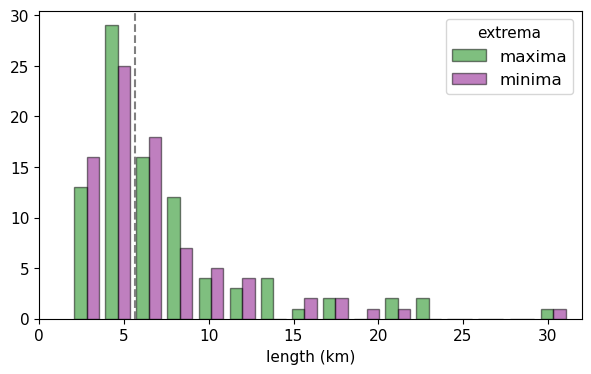

In [47]:
minima = all_data['extrema'] == 'minima'
maxima = all_data['extrema'] == 'maxima'
    
fig, ax = plt.subplots(figsize = (7,4))
n, bins, patches = plt.hist(x=[all_data['length'][maxima], all_data['length'][minima]], 
                            bins=16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)

plt.legend(['maxima', 'minima'], title = 'extrema', fontsize = 12, loc = 'upper right')

median = all_data['length'].median()
plt.axvline(x = median, linestyle = '--', c = 'grey')
print(median)

plt.xlabel('length (km)')
plt.xlim(0, 32)

### Height of features

Text(0.5, 0, 'height (m)')

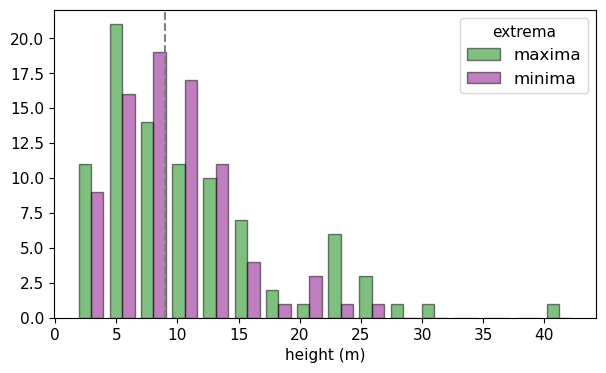

In [48]:
minima = all_data['extrema'] == 'minima'
maxima = all_data['extrema'] == 'maxima'
    
fig, ax = plt.subplots(figsize = (7,4))
n, bins, patches = plt.hist(x=[all_data['mean_height'][maxima], all_data['mean_height'][minima]], 
                            bins=16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)

plt.legend(['maxima', 'minima'], title = 'extrema', fontsize = 12, loc = 'upper right')

median = all_data['mean_height'].median()
plt.axvline(x = median, linestyle = '--', c = 'grey')

plt.xlabel('height (m)')

### Slope of features with respect to isopycnals

In [49]:
(100/10**-4)/86400

11.574074074074074

Text(0.5, 0, 'slope ($\\partial \\rho / \\partial x$)')

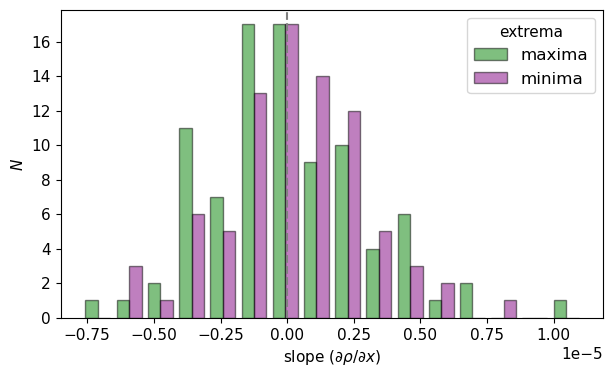

In [50]:
minima = chain_d_slopes['extrema'] == 'minima'
maxima = chain_d_slopes['extrema'] == 'maxima'
    
fig, ax = plt.subplots(figsize = (7,4))
n, bins, patches = plt.hist(x=[chain_d_slopes['slope'][maxima], chain_d_slopes['slope'][minima]], 
                            bins=16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)

plt.legend(['maxima', 'minima'], title = 'extrema', fontsize = 12, loc = 'upper right')
# plt.axvline(x = 0)

median = chain_d_slopes['slope'].median()
plt.axvline(x = median, linestyle = '--', c = 'grey')
ax.set_ylabel('$N$')
plt.xlabel(r'slope ($\partial \rho / \partial x$)')

### Slope of features with respect to isobars

median slope = -0.0018


Text(0, 0.5, '$N$')

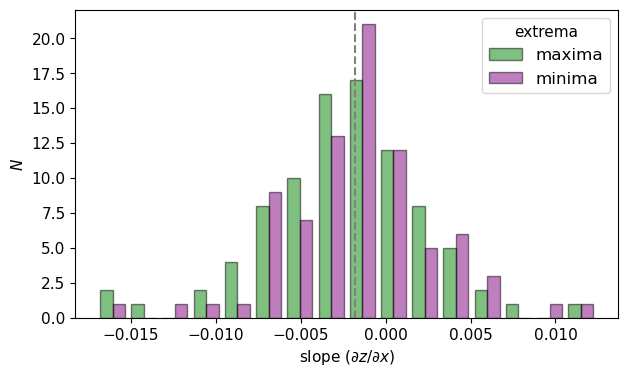

In [51]:
minima = chain_p_slopes['extrema'] == 'minima'
maxima = chain_p_slopes['extrema'] == 'maxima'
    
fig, ax = plt.subplots(figsize = (7,4))
n, bins, patches = plt.hist(x=[chain_p_slopes['slope'][maxima], chain_p_slopes['slope'][minima]], 
                            bins=16, edgecolor='black', color = ['green', 'purple'], 
                            alpha = 0.5, stacked = False)

plt.legend(['maxima', 'minima'], title = 'extrema', fontsize = 12, loc = 'upper right')

median = chain_p_slopes['slope'].median()
plt.axvline(x = median, linestyle = '--', c = 'grey')
print(f'median slope = {median:.2}')

# plt.axvline(x = 0, linestyle = '--', c = 'grey')
plt.xlabel(r'slope ($\partial z / \partial x$)')
ax.set_ylabel('$N$')
# ax.axvspan(xmin = -7.76e-3, xmax = 5.46e-3, color = 'grey', alpha = 0.25)

In [91]:
len(chain_p_slopes['slope'][abs(chain_p_slopes['slope']) >= 0.01])

7

In [92]:
len(chain_p_slopes['slope'])

147

In [93]:
7/147

0.047619047619047616

In [55]:
# minima = chain_p_slopes['extrema'] == 'minima'
# maxima = chain_p_slopes['extrema'] == 'maxima'
    
# fig, ax = plt.subplots(figsize = (7,4))
# n, bins, patches = plt.hist(x=[chain_p_slopes['abs_mean'][maxima], chain_p_slopes['abs_mean'][minima]], 
#                             bins=16, edgecolor='black', color = ['green', 'purple'],
#                             alpha = 0.5, stacked = False)

# plt.legend(['maxima', 'minima'], title = 'extrema', fontsize = 12, loc = 'upper right')

# median = chain_p_slopes['abs_mean'].median()
# plt.axvline(x = median, linestyle = '--', c = 'grey')
# print(f'median slope = {median:.2}')

# # plt.axvline(x = 0, linestyle = '--', c = 'grey')
# plt.xlabel(r'slope ($\partial z / \partial x$)')
# # ax.axvspan(xmin = -7.76e-3, xmax = 5.46e-3, color = 'grey', alpha = 0.25)
# plt.title('mean absolute slope of layers')
# ax.set_ylabel('$N$')

### Variability of slopes within each feature

In [366]:
slope_stats

chain  mean_slope  max_slope  mean_abs_slope  max_abs_slope  slope_std  \
0      0   -0.002096  -0.004589        0.002171       0.004589   0.001930   
1      1   -0.002615  -0.017526        0.006433       0.017526   0.008182   
2      2   -0.001118  -0.003092        0.002325       0.003092   0.002112   
3      3   -0.002039  -0.008663        0.003736       0.008663   0.004718   
4      4   -0.002386  -0.022217        0.005522       0.022217   0.007665   
..   ...         ...        ...             ...            ...        ...   
3      3   -0.005203  -0.012484        0.007281       0.012484   0.007281   
4      4   -0.002225  -0.009282        0.004848       0.009282   0.005256   
5      5    0.004147   0.013141        0.008994       0.013141   0.008994   
6      6   -0.002541  -0.009641        0.006274       0.009641   0.006265   
7      7   -0.001870  -0.014819        0.006726       0.014819   0.008300   

      pc_0.01  tow extrema  
0    0.000000  1.0  maxima  
1   20.000000  1.0  maxima  
2    0.000000  1.0  maxima  
3    0.000000  1.0  maxima  
4    9.090909  1.0  maxima  
..        ...  ...     ...  
3   50.000000  8.0  minima  
4    0.000000  8.0  minima  
5   50.000000  8.0  minima  
6    0.000000  8.0  minima  
7   33.333333  8.0  minima  

[147 rows x 9 columns]

median = 16.67%


Text(0.14, 1.02, '16.67')

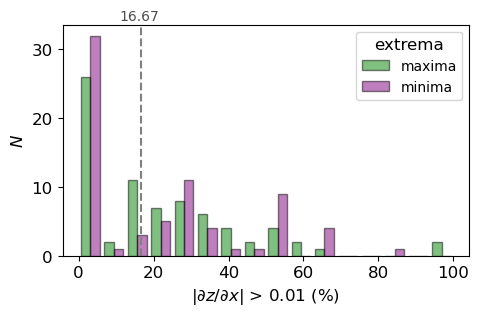

In [375]:
minima = slope_stats['extrema'] == 'minima'
maxima = slope_stats['extrema'] == 'maxima'
    
fig, ax = plt.subplots(figsize = (5.25,3))
n, bins, patches = plt.hist(x=[slope_stats['pc_0.01'][maxima], slope_stats['pc_0.01'][minima]], 
                            bins=16, edgecolor='black', color = ['green', 'purple'],
                            alpha = 0.5, stacked = False)

plt.legend(['maxima', 'minima'], title = 'extrema', fontsize = 10, loc = 'upper right')
# plt.axvline(x = 0)

median = slope_stats['pc_0.01'].median()
print(f'median = {median:.2f}%')
plt.axvline(x = median, linestyle = '--', c = 'grey')
ax.set_ylabel('$N$')
plt.xlabel(r'|$\partial z / \partial x$| > 0.01 (%)')
ax.text(0.14, 1.02, f'{median:.2f}', transform = ax.transAxes, c = 'k', alpha = 0.7, fontsize = 10)

In [376]:
# settings.save_figure(fig, my_path, 'appendix_slope_histogram.png', dpi = 600, pad = 0.2)

In [369]:
bins[8:]

array([ 50.  ,  56.25,  62.5 ,  68.75,  75.  ,  81.25,  87.5 ,  93.75,
       100.  ])

In [382]:
sum(n[0, 8:]) + sum(n[1, 8:])

23.0

In [383]:
np.sum(n[0]) + np.sum(n[1])

147.0

In [385]:
23/147*100

15.646258503401361

In [370]:
### percent of features that had at least 50% of slopes > 0.01

# Maxima
print('maxima:', sum(n[0, 8:])/np.sum(n[0])*100)

# Minima
print('minima:', sum(n[1, 8:])/np.sum(n[1])*100)

maxima: 12.0
minima: 19.444444444444446


Text(0.5, 1.0, '$\\partial z/ \\partial x$')

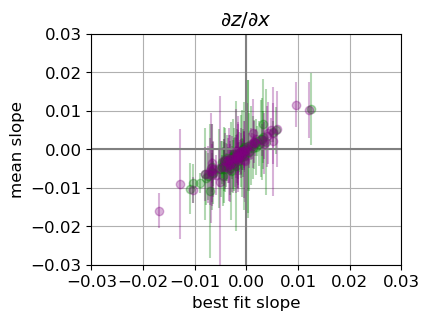

In [372]:
minima_best_fit = chain_p_slopes['extrema'] == 'minima'
maxima_best_fit = chain_p_slopes['extrema'] == 'maxima'

minima_avg_slope = slope_stats['extrema'] == 'minima'
maxima_avg_slope = slope_stats['extrema'] == 'maxima'

fig, ax = plt.subplots(figsize = (4,3))

plt.errorbar(chain_p_slopes['slope'][maxima_best_fit], slope_stats['mean_slope'][maxima_avg_slope], 
             yerr = slope_stats['slope_std'][maxima_avg_slope], fmt="o", c = 'green', alpha = 0.3)

plt.errorbar(chain_p_slopes['slope'][minima_best_fit], slope_stats['mean_slope'][minima_avg_slope], 
             yerr = slope_stats['slope_std'][minima_avg_slope], fmt="o", c = 'purple', alpha = 0.3)
plt.xlabel('best fit slope')
plt.ylabel('mean slope')
plt.xlim(-0.03, 0.03)
plt.ylim(-0.03, 0.03)
plt.grid()
plt.axvline(x = 0, c = 'grey')
plt.axhline(y = 0, c = 'grey')
plt.title(u'$\partial z/ \partial x$')

In [373]:
# settings.save_figure(fig, my_path, 'appendix_slope_scatter.png', dpi = 600, pad = 0.2)

In [388]:
slope_stats_min

chain  mean_slope  max_slope  mean_abs_slope  max_abs_slope  slope_std  \
0       0   -0.000584  -0.008483        0.005564       0.008483   0.005975   
1       1   -0.002903  -0.008894        0.005920       0.008894   0.005618   
2       2    0.001348   0.008597        0.003811       0.008597   0.004082   
3       3   -0.001669  -0.004641        0.001806       0.004641   0.002125   
4       4   -0.000999  -0.004152        0.003075       0.004152   0.003101   
5       5    0.004090   0.017539        0.006875       0.017539   0.007915   
6       6    0.010268   0.017629        0.010849       0.017629   0.007281   
7       7   -0.003084  -0.011898        0.010885       0.011898   0.010520   
8       8    0.001584   0.007259        0.002245       0.007259   0.003338   
9       9   -0.005057  -0.018707        0.007931       0.018707   0.008771   
10     10   -0.002243  -0.006995        0.003056       0.006995   0.003205   
11     11   -0.002862  -0.006346        0.003224       0.006346   0.002813   
12     12    0.003327   0.015168        0.007338       0.015168   0.007970   
13     13   -0.000216  -0.007830        0.003800       0.007830   0.004687   
14     14    0.004253   0.016625        0.008095       0.016625   0.008020   
15     15   -0.000400  -0.015582        0.007251       0.015582   0.008935   
16     16   -0.001923  -0.019875        0.007235       0.019875   0.009104   

      pc_0.01  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.000000  
5   33.333333  
6   50.000000  
7   66.666667  
8    0.000000  
9   25.000000  
10   0.000000  
11   0.000000  
12  20.000000  
13   0.000000  
14  26.923077  
15  30.000000  
16  20.000000

### Aspect ratio

In [1557]:
aspect_ratio = df['length']*1000/df['mean_height']
#larger aspect ratio = longer, thinner features

In [1558]:
aspect_ratio

0     534.560003
1     411.169041
2     997.046499
3     318.106994
4     623.807540
5     211.998355
6     510.079982
7    1168.769744
0    1151.856042
1    1138.828962
2     207.748552
3    1242.549557
4     632.007167
5     704.025244
dtype: float64

### Lateral T/S gradients

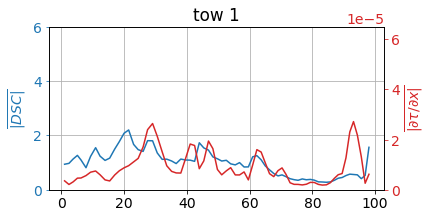

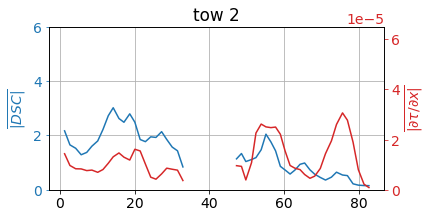

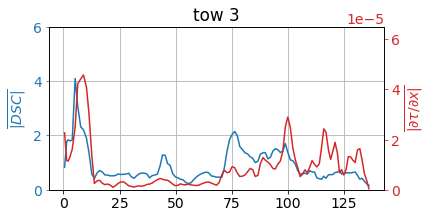

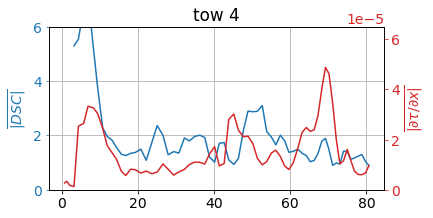

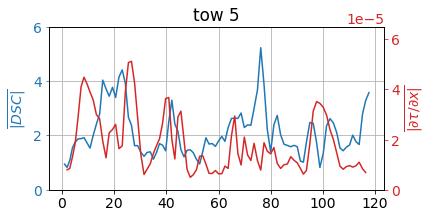

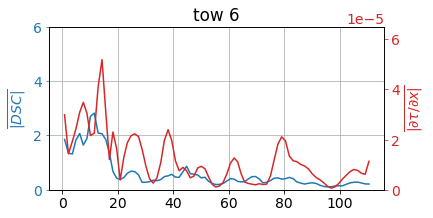

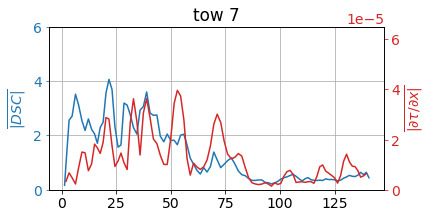

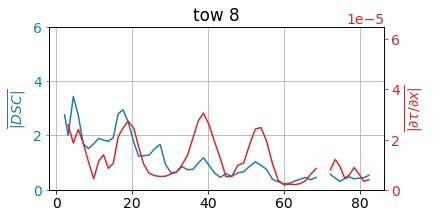

In [79]:
i = 1
for tow in lst:
    
    spice = gsw.spiciness1(S_dens[tow], T_dens[tow]).rolling(distance = 3, center = True, min_periods = 2).mean()
    spice_grad = (spice.differentiate('distance')/1000).rolling(distance = 3, center = True, min_periods = 2).mean()
    
    if tow == '02_002':
        ind = [24, 25]
        spice_grad[ind] = np.nan
    
    mld = calc.MLD_on_dens(d[tow].pdens, criteria = 0.02, pref = 10)
    
    dsc_avg = calc.mean_below_ml(abs(DSC_smooth[tow]), mld, zmax = 27.5, zdim = 'potential_density')
    spice_grad_avg = calc.mean_below_ml(abs(spice_grad), mld, zmax = 27.5, zdim = 'potential_density')
    
#     stats.spearmans(dsc_avg, spice_grad_avg)
#     stats.pearsons(dsc_avg, spice_grad_avg)
    
    fig, ax1 = plt.subplots(figsize = (6,3))
    ax1.plot(mld.distance, dsc_avg)
    ax1.set_ylabel(r'$\overline{|DSC|}$', c = 'tab:blue')
    ax1.tick_params(axis='y', colors='tab:blue')
    ax1.set_ylim(0,6)
    
    ax2 = ax1.twinx()
    ax2.plot(mld.distance, spice_grad_avg, c = 'tab:red')
    ax2.set_ylabel(r'$\overline{|\partial \tau / \partial x|}$', c = 'tab:red')
    ax2.tick_params(axis='y', colors='tab:red')
    ax2.set_title(f'tow {i}')
    ax2.set_ylim(0, 6.5e-5)
    
    ax1.grid()
    
    i+=1
    